In [2]:
import networkx as nx
import numpy as np
import scipy.io
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import scipy.stats
from scipy import signal
import os
import matplotlib.pyplot as plt

In [3]:
cwd = os.getcwd()

Get the coordinates of each node and the related name of the parcellation. In addition, load the file saying which hemisphere is affected (right or left). This is needed for having meaningful plots of our graph.

In [4]:
coordinates =  pd.read_csv('Parcellation.csv', delimiter=';')
coordinates = coordinates.drop(coordinates.index[[7,174]]) # nodes that should be removed (far from the rest)
coordinates

lesion_side = pd.read_csv('Side_lesion.csv')

# function to flip order of connectom according to lesion side
def flip_odd(C): #only call if lesion is in right hemisphere
    n = C.shape[0]
    assert(n % 2 == 1)
    breakpoint = (n - 1) // 2 + 1
    BS_BS = np.array(C[0, 0]).reshape(1,1)
    BS_HH = C[0, 1:breakpoint].reshape(1,-1)
    BS_AH = C[0, breakpoint:].reshape(1,-1)
    HH_BS = BS_HH.T
    HH_HH = C[1:breakpoint, 1:breakpoint]
    HH_AH = C[1:breakpoint, breakpoint:]

    AH_BS = BS_AH.T
    AH_HH = HH_AH.T
    AH_AH = C[breakpoint:, breakpoint:]

    return np.block([[BS_BS, BS_AH, BS_HH], [AH_BS, AH_AH, AH_HH], [HH_BS, HH_AH, HH_HH]])

## Initialization of adjacency matrices

**Load the adjacency matrices for each subject. For each subject we have for matrices:**
* Ca = connectome acute phase
* Cc = connectome chronic phase
* Da = dysconnectome actue phase
* Dc = dysconnectome chronic phase

Acute phase means that the respective MRI scan was taken 3 weeks after the stroke, chronic was taken 3 months after thre stroke.

We now want to see the impact of the lesion on the whole connectome and specifically on the unaffected part. For this analysis we want to redefine the dysconnectome and connectomes. For the dysconnectomes, once binarized, we will put the same weights present in the connectome for the same edges to know the FA. The connectome will be now considered as only healthy connectome (full connectome - Ca, minus the respective dysconnectome).
Our goal is to see what are the structural differences in time (from acute to chronic) in the affected and unaffected areas.

Additional goals are: 
* see if subjects having lesion in same region, have a similar brain reorganization
* see if subjects having lesion in same region, have a similar proportional recovery after 3 months

In [5]:
# Re-create the dysconnectomes (with connectome weights) and create the healthy connectome as connectome-dysconnectome
subjects = os.listdir('Data_Dysconnectome')

#fig, axs = plt.subplots(len(subjects),4,figsize=(32,32)) # initialize fig to plot degrees
#count = 0 # initialize counters for subplots

# initialize where to save the degrees with possible normalizations
acute_unaff_deg = np.zeros((333, len(subjects)-1))
acute_aff_deg = np.zeros((333, len(subjects)-1))
chronic_unaff_deg = np.zeros((333, len(subjects)-1))
chronic_aff_deg = np.zeros((333, len(subjects)-1))

acute_unaff_deg_avg_deg = np.zeros((333, len(subjects)-1))
acute_aff_deg_avg_deg = np.zeros((333, len(subjects)-1))
chronic_unaff_deg_avg_deg = np.zeros((333, len(subjects)-1))
chronic_aff_deg_avg_deg = np.zeros((333, len(subjects)-1))

acute_unaff_deg_edges = np.zeros((333, len(subjects)-1))
acute_aff_deg_edges = np.zeros((333, len(subjects)-1))
chronic_unaff_deg_edges = np.zeros((333, len(subjects)-1))
chronic_aff_deg_edges = np.zeros((333, len(subjects)-1))

acute_unaff_deg_nodes = np.zeros((333, len(subjects)-1))
acute_aff_deg_nodes = np.zeros((333, len(subjects)-1))
chronic_unaff_deg_nodes = np.zeros((333, len(subjects)-1))
chronic_aff_deg_nodes = np.zeros((333, len(subjects)-1))


# Go through the different subjects:
for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1

        # create new dysconnectomes (with FA values)
        Da_FA = np.multiply(Ca,Da_bin)
        Dc_FA = np.multiply(Cc,Dc_bin)
        
        Da_FA_bin = (Da_FA>0)*1
        Dc_FA_bin = (Dc_FA>0)*1
        
        # create healthy connectomes
        Ca_healthy = np.multiply((Ca_bin - Da_bin), Ca)
        Cc_healthy = np.multiply((Cc_bin - Dc_bin), Cc)
        Ca_healthy_bin = Ca_bin - Da_bin
        Cc_healthy_bin = Cc_bin - Dc_bin
        
        # get the degree of the new connectomes (only binarized)
        Ca_healthy_t = np.transpose(Ca_healthy)
        degree_Ca = np.sum(Ca_healthy + Ca_healthy_t, axis=0) 
        Cc_healthy_t = np.transpose(Cc_healthy)
        degree_Cc = np.sum(Cc_healthy + Cc_healthy_t, axis=0) 
        Da_FA_t = np.transpose(Da_FA)
        degree_Da = np.sum(Da_FA + Da_FA_t, axis=0) 
        Dc_FA_t = np.transpose(Dc_FA)
        degree_Dc = np.sum(Dc_FA + Dc_FA_t, axis=0) 
        
        acute_unaff_deg[:,idx-1] = degree_Ca
        acute_aff_deg[:,idx-1] = degree_Da
        chronic_unaff_deg[:,idx-1] = degree_Cc
        chronic_aff_deg[:,idx-1] = degree_Dc
        
        # normalize by the average degree of each subject
        acute_unaff_deg_avg_deg[:,idx-1] = acute_unaff_deg[:,idx-1]/np.mean(degree_Ca)
        acute_aff_deg_avg_deg[:,idx-1] = acute_aff_deg[:,idx-1]/np.mean(degree_Da)
        chronic_unaff_deg_avg_deg[:,idx-1] = chronic_unaff_deg[:,idx-1]/np.mean(degree_Cc)
        chronic_aff_deg_avg_deg[:,idx-1] = chronic_unaff_deg[:,idx-1]/np.mean(degree_Dc)
        
        # normalize by the tot number of edges for each subject
        acute_unaff_deg_edges[:,idx-1] = acute_unaff_deg[:,idx-1]/np.count_nonzero(Ca_healthy)
        acute_aff_deg_edges[:,idx-1] = acute_aff_deg[:,idx-1]/np.count_nonzero(Da_FA)
        chronic_unaff_deg_edges[:,idx-1] = chronic_unaff_deg[:,idx-1]/np.count_nonzero(Cc_healthy)
        chronic_aff_deg_edges[:,idx-1] = chronic_unaff_deg[:,idx-1]/np.count_nonzero(Dc_FA)
        
        # normalize by the tot number of nodes in the connectome
        acute_unaff_deg_nodes[:,idx-1] = acute_unaff_deg[:,idx-1]/333
        acute_aff_deg_nodes[:,idx-1] = acute_aff_deg[:,idx-1]/333
        chronic_unaff_deg_nodes[:,idx-1] = chronic_unaff_deg[:,idx-1]/333
        chronic_aff_deg_nodes[:,idx-1] = chronic_unaff_deg[:,idx-1]/333
        
        ## plot distributions for each subject
        #axs[idx][0].hist(degree_Ca);
        #axs[idx][0].set_title('Ca')
        #axs[idx][1].hist(degree_Cc);
        #axs[idx][1].set_title('Cc')
        #axs[idx][2].hist(degree_Da);
        #axs[idx][2].set_title('Da')
        #axs[idx][3].hist(degree_Dc);
        #axs[idx][3].set_title('Dc')
        
        # find 15 biggest hubs
        hubs_Ca_bin = np.unravel_index(np.argsort(degree_Ca, axis=None), degree_Ca.shape)[0][-6:-1]
        hubs_Cc_bin = np.unravel_index(np.argsort(degree_Cc, axis=None), degree_Cc.shape)[0][-6:-1]
        hubs_Da_bin = np.unravel_index(np.argsort(degree_Da, axis=None), degree_Da.shape)[0][-6:-1]
        hubs_Dc_bin = np.unravel_index(np.argsort(degree_Dc, axis=None), degree_Dc.shape)[0][-6:-1]
        #print('\n\n', subject, ' - 5 biggest hubs:')
        #print(hubs_Ca_bin, hubs_Cc_bin)
        #print(degree_Ca[hubs_Ca_bin], degree_Cc[hubs_Cc_bin])
        #print('\n',hubs_Da_bin, hubs_Dc_bin)
        #print(degree_Da[hubs_Da_bin], degree_Dc[hubs_Dc_bin])
        
        

In which nodes, across subjects, do we see the largest difference in terms of connected edges (degree) when moving from acute to chronic phase?

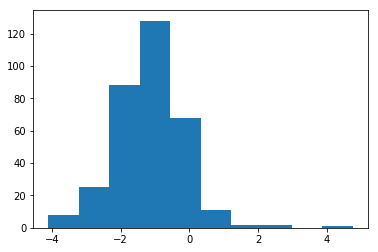

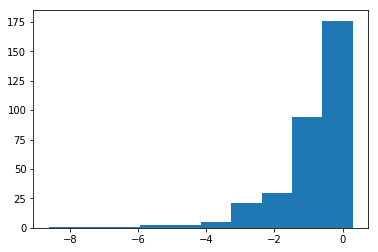

[-8.62685962e+00 -2.39589320e+00 -1.08832243e+00 -1.39794439e+00
 -1.28979929e+00 -3.11616358e-01 -3.53322463e+00 -6.11844189e-01
 -8.57423072e-01 -4.55830857e-01 -1.55370221e-01 -5.02904880e-01
 -4.38131265e-01 -8.56213355e-02 -1.76598915e-01 -1.60298271e-01
 -3.03213320e-01 -5.76388648e-02 -3.17889288e-01 -5.01577942e-01
  2.51544045e-03 -1.78404243e-01 -3.01753257e-01 -1.24216334e-01
  5.21649428e-02 -1.68313922e-01 -2.97210779e-01 -3.74797846e-01
 -1.01954968e-01 -1.69658907e-01 -4.66889810e-01 -4.02920022e-01
 -3.94893409e-01 -1.04068117e+00 -9.30588842e-01 -1.11120377e+00
 -6.36426862e-01 -5.35479430e-01  1.48488784e-01 -2.27782909e-01
 -4.45970437e-02 -4.18071198e-01 -3.84301167e-01 -5.03104086e-01
 -5.18019877e-01 -2.67991201e-02  2.39381443e-02  2.60742877e-02
 -1.11587644e-01 -2.22862791e-01 -8.35157493e-02  2.23149037e-02
 -3.41809485e-02 -4.29069081e-01 -2.01780850e-01 -1.97238559e-01
 -2.11284107e-01 -1.45578946e-01 -6.67448967e-02  3.00024037e-01
  7.21299623e-03 -5.33088

In [123]:
# where do I have the max differences?
diff_aff = chronic_aff_deg - acute_aff_deg
diff_aff_avg_deg = chronic_aff_deg_avg_deg - acute_aff_deg_avg_deg
diff_aff_edges = chronic_aff_deg_edges - acute_aff_deg_edges
diff_aff_nodes = chronic_aff_deg_nodes - acute_aff_deg_nodes

diff_unaff = chronic_unaff_deg - acute_unaff_deg
diff_unaff_avg_deg = chronic_unaff_deg_avg_deg - acute_unaff_deg_avg_deg
diff_unaff_edges = chronic_unaff_deg_edges - acute_unaff_deg_edges
diff_unaff_nodes = chronic_unaff_deg_nodes - acute_unaff_deg_nodes

# is there statistical difference on average across subjects between structural differences in heathy and affected connectomes?
stats_avg_deg = scipy.stats.ranksums(np.mean(diff_unaff_avg_deg, axis = 1), np.mean(diff_aff_avg_deg, axis=1))
stats_edges = scipy.stats.ranksums(np.mean(diff_unaff_edges, axis = 1), np.mean(diff_aff_edges, axis=1))
stats_nodes = scipy.stats.ranksums(np.mean(diff_unaff_nodes, axis = 1), np.mean(diff_aff_nodes, axis=1))
plt.figure();
plt.hist(np.mean(diff_unaff, axis = 1));
plt.show()
plt.figure();
plt.hist(np.mean(diff_aff, axis = 1))
plt.show()

print(np.mean(diff_aff, axis = 1))

In [161]:
# do I have many changes from chronic to acute, where are they mostly located
print('Percentage of degree changes in dysconnectome: ', np.count_nonzero(diff_aff)/(333*(len(subjects)-1)))
print('Percentage of degree changes in healthy connectome: ', np.count_nonzero(diff_unaff)/(333*(len(subjects)-1)))

# do changes occur in the hubs or not?
# count the occurence of hubs, choose the biggest. What is the average change there, what is the fraction compared to 
# to the total change?


# Again, go through all the subjects to save new arrays
hubs_Ca = []
hubs_Cc = []
hubs_Da = []
hubs_Dc = []

acute_unaff_deg_norm = np.zeros((333, len(subjects)-1))
acute_aff_deg_norm = np.zeros((333, len(subjects)-1))
chronic_unaff_deg_norm = np.zeros((333, len(subjects)-1))
chronic_aff_deg_norm = np.zeros((333, len(subjects)-1))

acute_unaff_deg_norm_max = np.zeros((333, len(subjects)-1))
acute_aff_deg_norm_max = np.zeros((333, len(subjects)-1))
chronic_unaff_deg_norm_max = np.zeros((333, len(subjects)-1))
chronic_aff_deg_norm_max = np.zeros((333, len(subjects)-1))

for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1

        # create new dysconnectomes (with FA values)
        Da_FA = np.multiply(Ca,Da_bin)
        Dc_FA = np.multiply(Cc,Dc_bin)
        
        Da_FA_norm = Da_FA/np.max(Da_FA)
        Dc_FA_norm = Dc_FA/np.max(Dc_FA)
        
        # create healthy connectomes
        Ca_healthy = np.multiply((Ca_bin - Da_bin), Ca)
        Cc_healthy = np.multiply((Cc_bin - Dc_bin), Cc)
        Ca_healthy_norm = Ca_healthy/np.max(Ca_healthy)
        Cc_healthy_norm = Cc_healthy/np.max(Cc_healthy)
        # get the degree of the new connectomes (only binarized)
        Ca_healthy_norm_t = np.transpose(Ca_healthy_norm)
        degree_Ca = np.sum(Ca_healthy_norm + Ca_healthy_norm_t, axis=0) 
        Cc_healthy_norm_t = np.transpose(Cc_healthy_norm)
        degree_Cc = np.sum(Cc_healthy_norm + Cc_healthy_norm_t, axis=0) 
        Da_FA_norm_t = np.transpose(Da_FA_norm)
        degree_Da = np.sum(Da_FA_norm + Da_FA_norm_t, axis=0) 
        Dc_FA_norm_t = np.transpose(Dc_FA_norm)
        degree_Dc = np.sum(Dc_FA_norm + Dc_FA_norm_t, axis=0)  
        
        acute_unaff_deg_norm[:,idx-1] = degree_Ca
        acute_aff_deg_norm[:,idx-1] = degree_Da
        chronic_unaff_deg_norm[:,idx-1] = degree_Cc
        chronic_aff_deg_norm[:,idx-1] = degree_Dc
        
        acute_unaff_deg_norm_max[:,idx-1] = degree_Ca/np.max(degree_Ca)
        acute_aff_deg_norm_max[:,idx-1] = degree_Da/np.max(degree_Da)
        chronic_unaff_deg_norm_max[:,idx-1] = degree_Cc/np.max(degree_Cc)
        chronic_aff_deg_norm_max[:,idx-1] = degree_Dc/np.max(degree_Dc)
        
        
          
        # find 15 biggest hubs
        hubs_Ca.append(list(np.unravel_index(np.argsort(degree_Ca, axis=None), degree_Ca.shape)[0][-11:-1]))
        hubs_Cc.append(list(np.unravel_index(np.argsort(degree_Cc, axis=None), degree_Cc.shape)[0][-11:-1]))
        hubs_Da.append(list(np.unravel_index(np.argsort(degree_Da, axis=None), degree_Da.shape)[0][-11:-1]))
        hubs_Dc.append(list(np.unravel_index(np.argsort(degree_Dc, axis=None), degree_Dc.shape)[0][-11:-1]))

Percentage of degree changes in dysconnectome:  0.7921254587921255
Percentage of degree changes in healthy connectome:  0.9914199914199914


In [127]:
diff_aff_norm_max = chronic_unaff_deg_norm_max-acute_unaff_deg_norm_max
diff_unaff_norm_max = chronic_aff_deg_norm_max-acute_aff_deg_norm_max
print('Percentage of degree changes in dysconnectome: ', np.sum(abs(diff_aff_norm_max))/(333*(len(subjects)-1)))
print('Percentage of degree changes in healthy connectome: ', np.sum(abs(diff_unaff_norm_max))/(333*(len(subjects)-1)))


#print(degree_Ca)
print(np.mean(diff_aff), np.std(diff_aff))
print(np.mean(diff_unaff), np.std(diff_unaff))

diff_aff_norm = chronic_aff_deg_norm - acute_aff_deg_norm
diff_unaff_norm = chronic_unaff_deg_norm - acute_unaff_deg_norm
print(np.mean(diff_aff_norm), np.std(diff_aff_norm))
print(np.mean(diff_unaff_norm), np.std(diff_unaff_norm))
print('Percentage of degree changes in dysconnectome: ', np.sum(abs(diff_aff)))
print('Percentage of degree changes in healthy connectome: ', np.sum(abs(diff_unaff)))

Percentage of degree changes in dysconnectome:  0.0593898264706228
Percentage of degree changes in healthy connectome:  0.031714788519513815
-0.9165894775634922 3.9714564701620216
-1.1428033055886073 7.8581971535765485
-1.5151275149839287 6.807285038550034
-0.542534181402678 10.996700862928876
Percentage of degree changes in dysconnectome:  41517.797643730795
Percentage of degree changes in healthy connectome:  107540.28451045949


Start to see where the hubs are located and how they change in time. Analyses done over all the subjects

Text(0.5, 1.0, 'Dysconnectome, chronic')

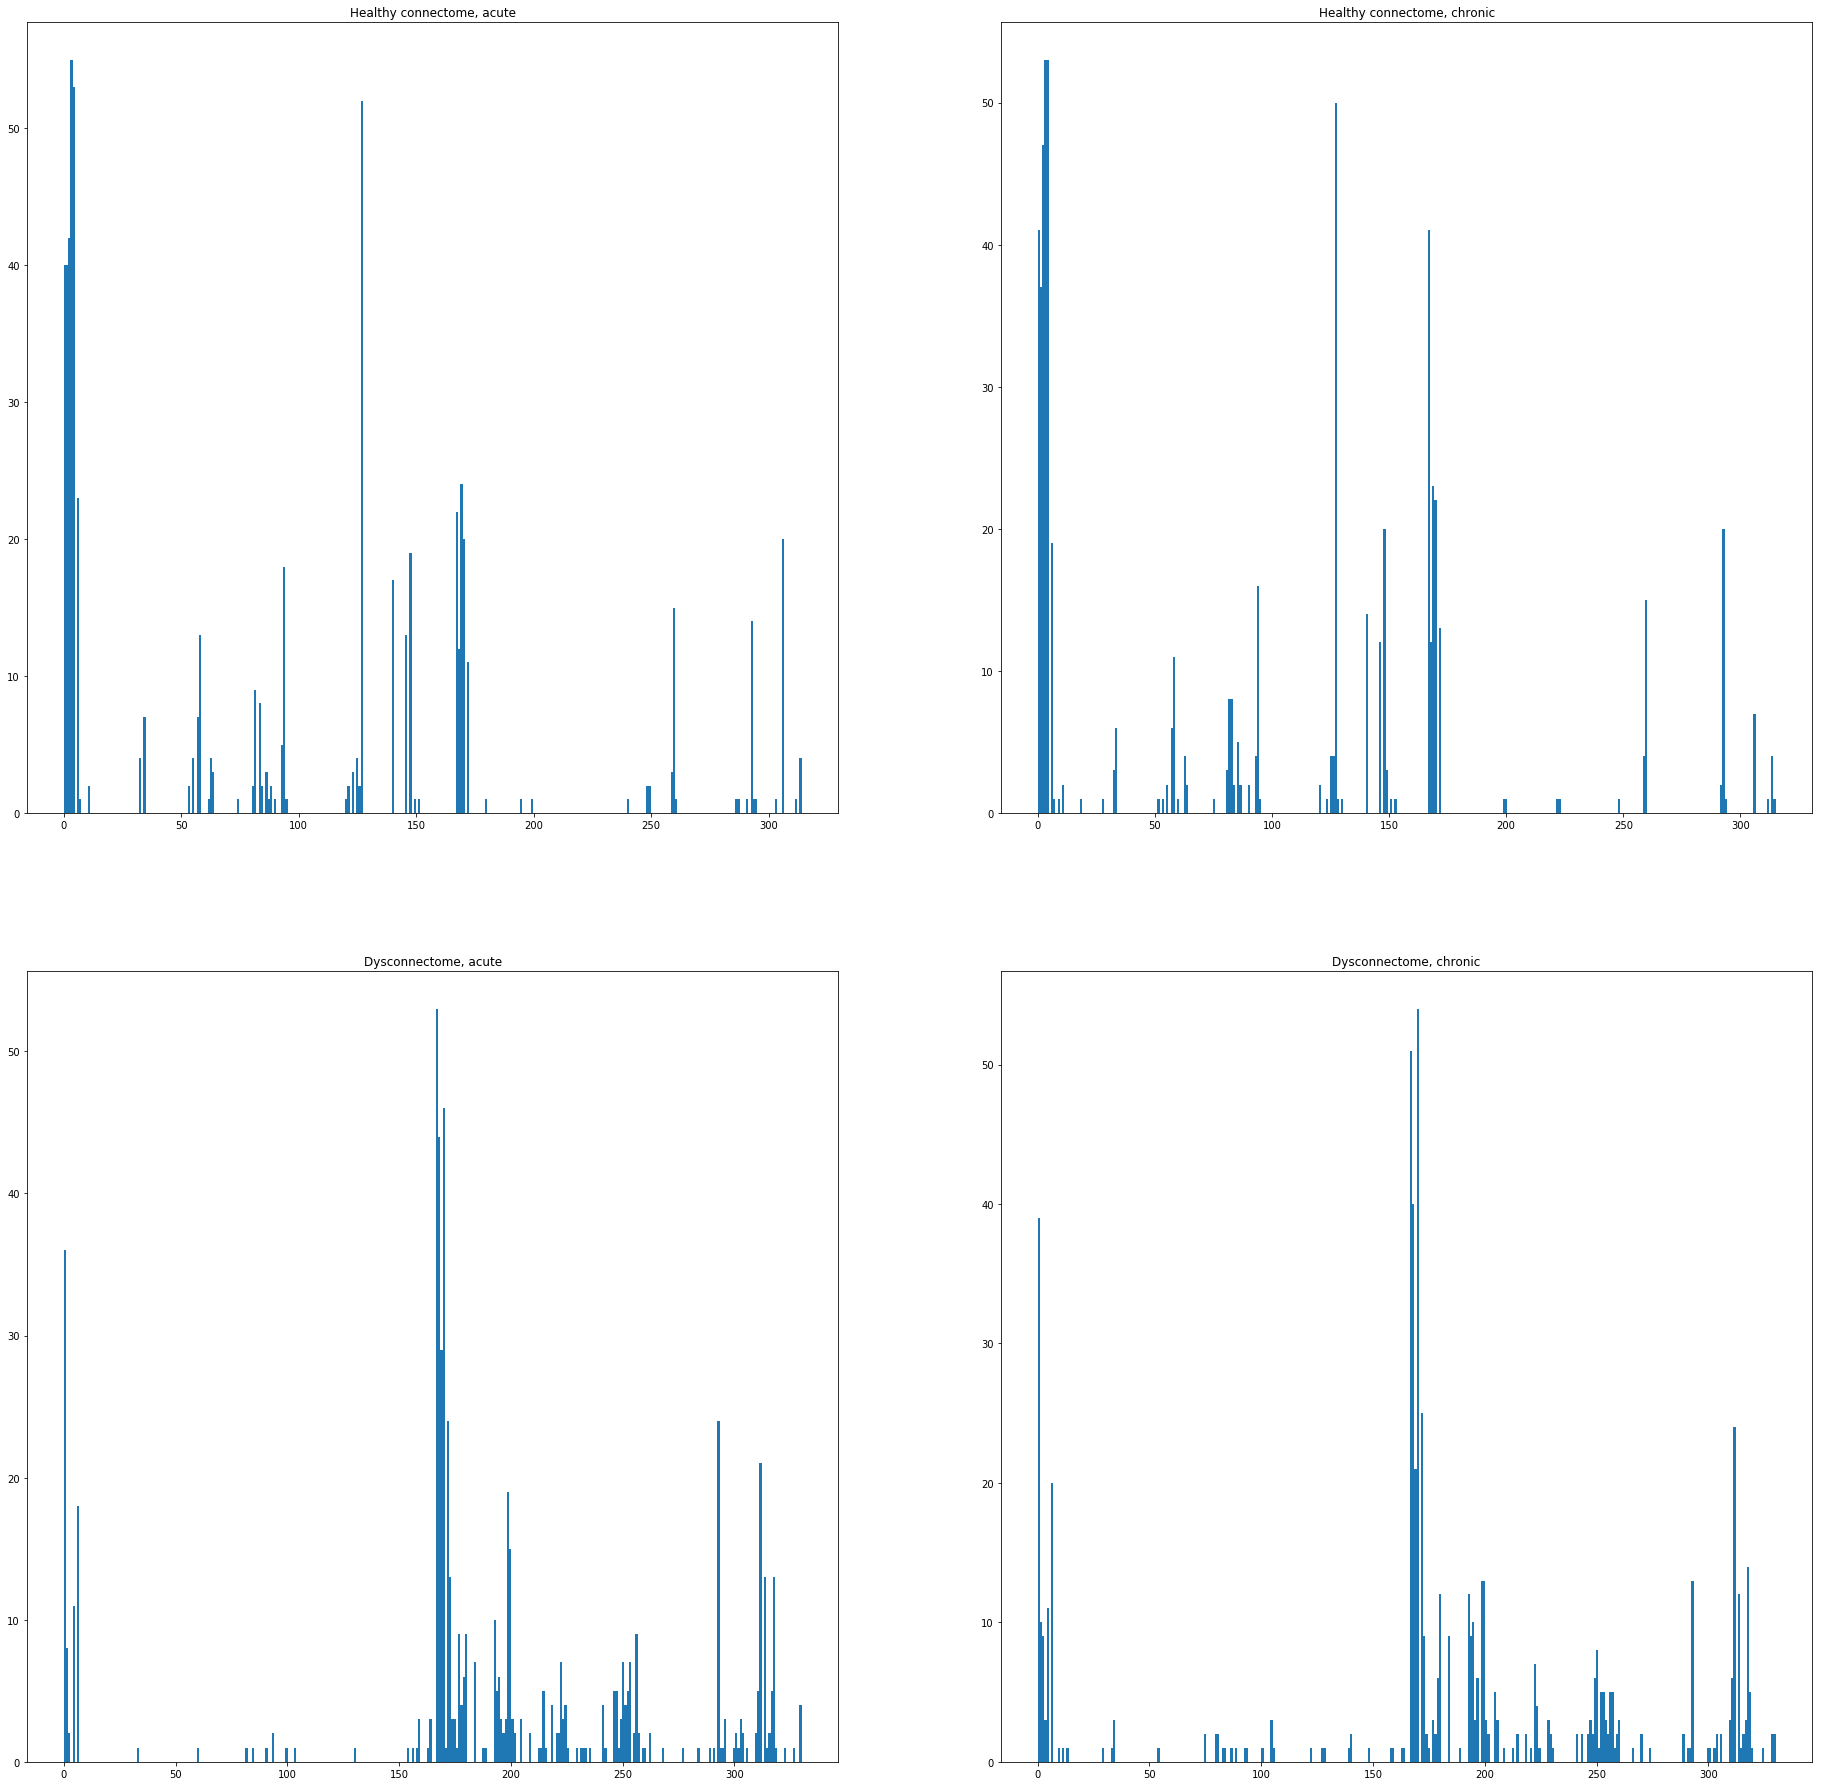

In [8]:
fig, axs = plt.subplots(2,2,figsize=(32,32)) # initialize fig to plot hubs
hubs_Ca_r = np.reshape(hubs_Ca, (1,630))
hubs_Cc_r = np.reshape(hubs_Cc, (1,630))
hubs_Da_r = np.reshape(hubs_Da, (1,630))
hubs_Dc_r = np.reshape(hubs_Dc, (1,630))

ax0 = axs[0][0]
ax0.hist(hubs_Ca_r[0],bins=333)
ax0.set_title('Healthy connectome, acute')
ax1 = axs[0][1]
ax1.hist(hubs_Cc_r[0],bins=333)
ax1.set_title('Healthy connectome, chronic')
ax2 = axs[1][0]
ax2.hist(hubs_Da_r[0],bins=333)
ax2.set_title('Dysconnectome, acute')
ax3 = axs[1][1]
ax3.hist(hubs_Dc_r[0],bins=333)
ax3.set_title('Dysconnectome, chronic')



For each timepoint, find the hubs with highes occurence. Are they similar between acute and chronic phase?

In [9]:
from collections import Counter
most_common_hubs_Ca = [h for h, h_count in  Counter(list(hubs_Ca_r[0])).most_common(10)]
most_common_hubs_Cc = [h for h, h_count in  Counter(list(hubs_Cc_r[0])).most_common(10)]
most_common_hubs_Da = [h for h, h_count in  Counter(list(hubs_Da_r[0])).most_common(10)]
most_common_hubs_Dc = [h for h, h_count in  Counter(list(hubs_Dc_r[0])).most_common(10)]
print(most_common_hubs_Ca)
print(most_common_hubs_Cc)
# the most common hubs in healthy connectomes across subjects are the same
print(most_common_hubs_Da)
print(most_common_hubs_Dc)
# most commond hubs in dysconnectomes are similiar but not as much as in healthy connectomes

[3, 4, 127, 2, 0, 1, 169, 6, 167, 170]
[4, 3, 127, 2, 167, 0, 1, 169, 170, 293]
[167, 170, 168, 0, 169, 172, 293, 312, 199, 6]
[170, 167, 168, 0, 172, 312, 169, 6, 318, 200]


In [10]:
# what is the percentage of change in degrees in the hubs compared to the total change?
print(np.sum(abs(diff_aff[most_common_hubs_Da]))/np.sum(abs(diff_aff))) # not big change either, also in this case quite similar the hubs nodes in time
print(np.sum(abs(diff_unaff[most_common_hubs_Ca]))/np.sum(abs(diff_unaff))) # expected low values as connectomes are the same in time


0.11194269140372308
0.0446895320806247


In [11]:
# if the change is not in the hubs, is it somewhere else?
diff_unaff_m = np.mean(abs(diff_unaff_nodes), axis=1)-np.std(abs(diff_unaff_nodes),axis=1)
diff_aff_m = np.mean(abs(diff_aff_nodes), axis=1)-np.std(abs(diff_aff_nodes),axis=1)
#print(find(np.max(np.mean(diff_unaff))))
ind = np.argpartition(diff_unaff_m, -10)[-10:]
print(coordinates.iloc[ind]['Areaname'])
ind = np.argpartition(diff_aff_m, -10)[-10:]
print(coordinates.iloc[ind]['Areaname'])


225       lh_G_temp_sup-Lateral_div1
9                         rh_M1_div2
119              rh_S_calcarine_div1
168                      lh_Thalamus
90     rh_G_pariet_inf-Supramar_div1
101    rh_S_intrapariet&P_trans_div2
6                      rh_Cerebellum
0                          BrainStem
55          rh_G_temp_sup-G_T_transv
173                    lh_Cerebellum
Name: Areaname, dtype: object
58        rh_G_temp_sup-Lateral_div1
149    rh_S_circular_insula_inf_div1
170                       lh_Putamen
4                        rh_Pallidum
1                        rh_Thalamus
59        rh_G_temp_sup-Lateral_div2
3                         rh_Putamen
2                         rh_Caudate
128                   rh_Hippocampus
147               rh_G_insular_short
Name: Areaname, dtype: object


Now that we have seen how all the subjects behave, start to look at the grouped subjects in terms of lesion location

In [119]:
# Cluster the subjects according to their lesion location. NB: we consider only groups of subjects of at least 3. If a subject is the only one having a certain lesion location, will not be clustered nor considered
lesion_loc = ['SC', 'CR', 'Pons', 'Peri-insular']
lesion_loc_df = pd.read_csv('Properties_lesion.csv', delimiter=';')


SC_idx = np.nonzero((lesion_loc_df['location']=='SC')*1)
CR_idx = np.nonzero((lesion_loc_df['location']=='CR')*1)
pons_idx = np.nonzero((lesion_loc_df['location']=='Pons')*1)
peri_idx = np.nonzero((lesion_loc_df['location']=='Peri-insular')*1)
list_tot = list(SC_idx[0]) + list(CR_idx[0])+ list(pons_idx[0]) + list(peri_idx[0])
others_idx = [n for n in range(62) if n not in list_tot]

# get the matrices of the degrees considering only these indices
diff_aff_avg_deg_SC = diff_aff_avg_deg[:,SC_idx[0]]
diff_aff_avg_deg_CR = diff_aff_avg_deg[:,CR_idx[0]]
diff_aff_avg_deg_pons = diff_aff_avg_deg[:,pons_idx[0]]
diff_aff_avg_deg_peri = diff_aff_avg_deg[:,peri_idx[0]]
diff_aff_avg_deg_others = diff_aff_avg_deg[:,others_idx]

diff_unaff_avg_deg_SC = diff_unaff_avg_deg[:,SC_idx[0]]
diff_unaff_avg_deg_CR = diff_unaff_avg_deg[:,CR_idx[0]]
diff_unaff_avg_deg_pons = diff_unaff_avg_deg[:,pons_idx[0]]
diff_unaff_avg_deg_peri = diff_unaff_avg_deg[:,peri_idx[0]]
diff_unaff_avg_deg_others = diff_unaff_avg_deg[:,others_idx]



In [121]:
diff_unaff_m = np.mean(abs(diff_unaff_avg_deg_SC), axis=1)-np.std(abs(diff_unaff_avg_deg_SC),axis=1)
diff_aff_m = np.mean(abs(diff_aff_avg_deg_SC), axis=1)-np.std(abs(diff_aff_avg_deg_SC),axis=1)
ind = np.argpartition(diff_unaff_m, -5)[-5:]
print('Healthy SC_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print(diff_unaff_m[ind])

ind = np.argpartition(diff_aff_m, -5)[-5:]
print('Dysc SC_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print(diff_aff_m[ind])
print('\n\n')


diff_unaff_m = np.mean(abs(diff_unaff_avg_deg_CR), axis=1)-np.std(abs(diff_unaff_avg_deg_CR),axis=1)
diff_aff_m = np.mean(abs(diff_aff_avg_deg_CR), axis=1)-np.std(abs(diff_aff_avg_deg_CR),axis=1)
ind = np.argpartition(diff_unaff_m, -5)[-5:]
print('Healthy CR_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
ind = np.argpartition(diff_aff_m, -5)[-5:]
print('Dysc CR_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print('\n\n')

diff_unaff_m = np.mean(abs(diff_unaff_avg_deg_pons), axis=1)-np.std(abs(diff_unaff_avg_deg_pons),axis=1)
diff_aff_m = np.mean(abs(diff_aff_avg_deg_pons), axis=1)-np.std(abs(diff_aff_avg_deg_pons),axis=1)
ind = np.argpartition(diff_unaff_m, -5)[-5:]
print('Healthy pons_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
ind = np.argpartition(diff_aff_m, -5)[-5:]
print('Dysc pons_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print('\n\n')

diff_unaff_m = np.mean(abs(diff_unaff_avg_deg_peri), axis=1)-np.std(abs(diff_unaff_avg_deg_peri),axis=1)
diff_aff_m = np.mean(abs(diff_aff_avg_deg_peri), axis=1)-np.std(abs(diff_aff_avg_deg_peri),axis=1)
print('peri max differences')
ind = []
print('healthy')
ind = np.argpartition(diff_unaff_m, -5)[-5:]
print('Healthy peri-insular_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
ind = np.argpartition(diff_aff_m, -5)[-5:]
print('Dysconnectome peri-insular_lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print('\n\n')

diff_unaff_m = np.mean(abs(diff_unaff_avg_deg_others), axis=1)-np.std(abs(diff_unaff_avg_deg_others),axis=1)
diff_aff_m = np.mean(abs(diff_aff_avg_deg_others), axis=1)-np.std(abs(diff_aff_avg_deg_others),axis=1)
print('others max differences')
ind = []
print('healthy')
ind = np.argpartition(diff_unaff_m, -5)[-5:]
print('Healthy other lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
ind = np.argpartition(diff_aff_m, -5)[-5:]
print('Dysconnectome other lesion\n',coordinates.iloc[ind]['Areaname'],'\n')
print(ind)
    #print(diff_unaff_m[ind])
print('\n\n')

Healthy SC_lesion
 309           lh_S_pericallosal_div2
304      lh_G&S_cingul-Mid-Post_div1
90     rh_G_pariet_inf-Supramar_div1
129          rh_G_cingul-Post-dorsal
225       lh_G_temp_sup-Lateral_div1
Name: Areaname, dtype: object 

[0.13353612 0.16461273 0.13913863 0.15300262 0.13677092]
Dysc SC_lesion
 144          rh_Lat_Fis-ant-Vertical
164    rh_G_oc-temp_med-Parahip_div1
21              rh_S_orbital_lateral
90     rh_G_pariet_inf-Supramar_div1
60            rh_G_temporal_inf_div1
Name: Areaname, dtype: object 

[0.13183824 0.14099342 0.1747913  1.0023119  1.01742576]



Healthy CR_lesion
 262            lh_G_precuneus_div2
64       rh_G_temporal_middle_div2
261            lh_G_precuneus_div1
6                    rh_Cerebellum
153    rh_G_Ins_lg&S_cent_ins_div1
Name: Areaname, dtype: object 

Dysc CR_lesion
 2          rh_Caudate
128    rh_Hippocampus
3          rh_Putamen
4         rh_Pallidum
1         rh_Thalamus
Name: Areaname, dtype: object 




Healthy pons_lesion
 110   

peri max differences
healthy
0           BrainStem
168       lh_Thalamus
295    lh_Hippocampus
Name: Areaname, dtype: object
dysconnetome
1             rh_Thalamus
3              rh_Putamen
4             rh_Pallidum
95    rh_G_precuneus_div2
Name: Areaname, dtype: object



CR max differences
healthy
Series([], Name: Areaname, dtype: object)
dysconnetome
1    rh_Thalamus
3     rh_Putamen
4    rh_Pallidum
Name: Areaname, dtype: object



pons max differences
healthy
Series([], Name: Areaname, dtype: object)
dysconnetome
1      rh_Thalamus
3       rh_Putamen
4      rh_Pallidum
168    lh_Thalamus
170     lh_Putamen
171    lh_Pallidum
Name: Areaname, dtype: object



SC max differences
healthy
Series([], Name: Areaname, dtype: object)
dysconnetome
1    rh_Thalamus
3     rh_Putamen
4    rh_Pallidum
Name: Areaname, dtype: object



Other lesions max differences
healthy
Series([], Name: Areaname, dtype: object)
dysconnetome
1    rh_Thalamus
3     rh_Putamen
4    rh_Pallidum
Name: Areaname, dt

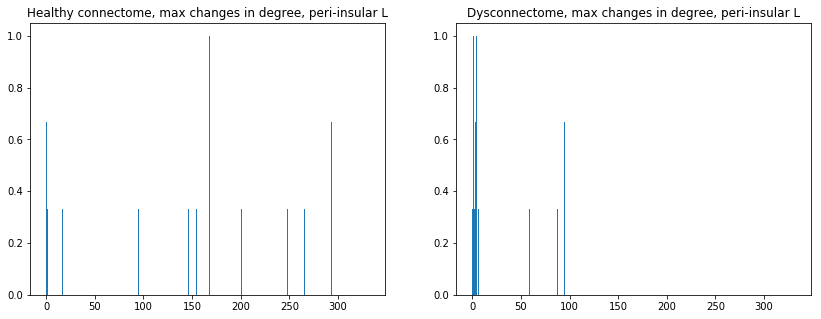

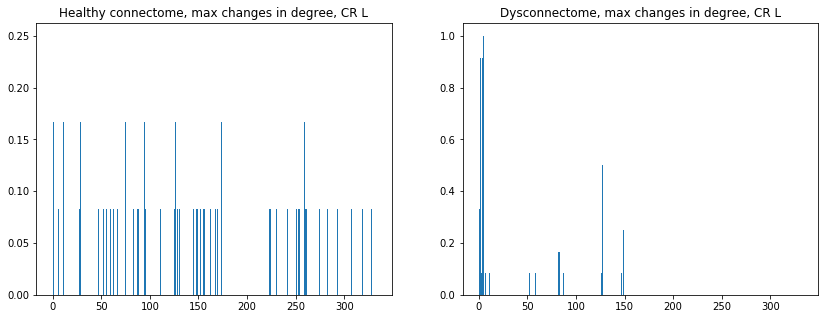

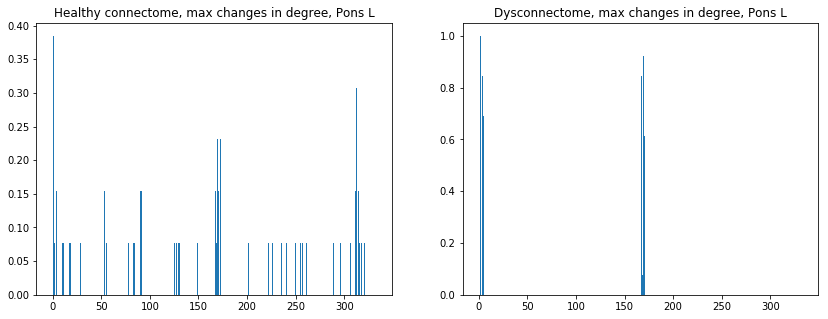

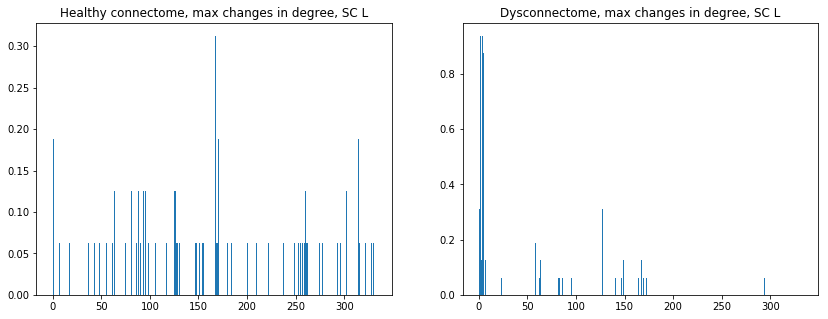

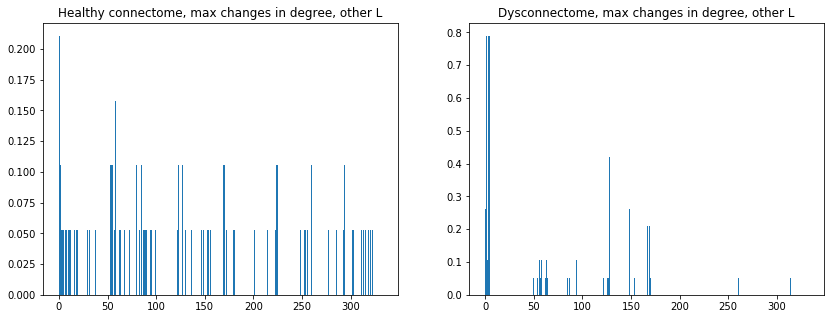

In [83]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
print('peri max differences')
ind = []
print('healthy')
for idx in range(np.size(peri_idx)):
    ind = ind+(list(np.argpartition(diff_unaff_avg_deg_peri[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(peri_idx))
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
axs[0].set_title('Healthy connectome, max changes in degree, peri-insular L')
print('dysconnetome')
ind = []
for idx in range(np.size(peri_idx)):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg_peri[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(peri_idx))
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
axs[1].set_title('Dysconnectome, max changes in degree, peri-insular L')
print('\n\n')

fig, axs = plt.subplots(1,2,figsize=(14,5))
print('CR max differences')
ind = []
print('healthy')
for idx in range(np.size(CR_idx)):
    ind = ind+(list(np.argpartition(diff_unaff_avg_deg_CR[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(CR_idx))
axs[0].set_title('Healthy connectome, max changes in degree, CR L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('dysconnetome')
ind = []
for idx in range(np.size(CR_idx)):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg_CR[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(CR_idx))
axs[1].set_title('Dysconnectome, max changes in degree, CR L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('\n\n')

fig, axs = plt.subplots(1,2,figsize=(14,5))
print('pons max differences')
ind = []
print('healthy')
for idx in range(np.size(pons_idx)):
    ind=ind+(list(np.argpartition(diff_unaff_avg_deg_pons[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(pons_idx))
axs[0].set_title('Healthy connectome, max changes in degree, Pons L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('dysconnetome')
ind = []
for idx in range(np.size(pons_idx)):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg_pons[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(pons_idx))
axs[1].set_title('Dysconnectome, max changes in degree, Pons L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('\n\n')

fig, axs = plt.subplots(1,2,figsize=(14,5))
print('SC max differences')
ind = []
print('healthy')
for idx in range(np.size(SC_idx)):
    ind = ind+(list(np.argpartition(diff_unaff_avg_deg_SC[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(SC_idx))
axs[0].set_title('Healthy connectome, max changes in degree, SC L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('dysconnetome')
ind = []
for idx in range(np.size(SC_idx)):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg_SC[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(SC_idx))
axs[1].set_title('Dysconnectome, max changes in degree, SC L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('\n\n')

fig, axs = plt.subplots(1,2,figsize=(14,5))
print('Other lesions max differences')
ind = []
print('healthy')
for idx in range(np.size(others_idx)):
    ind = ind+(list(np.argpartition(diff_unaff_avg_deg_others[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(others_idx))
axs[0].set_title('Healthy connectome, max changes in degree, other L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('dysconnetome')
ind = []
for idx in range(np.size(others_idx)):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg_others[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/np.size(others_idx))
axs[1].set_title('Dysconnectome, max changes in degree, other L')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('\n\n')

Text(0.5, 1.0, 'Dc hubs')

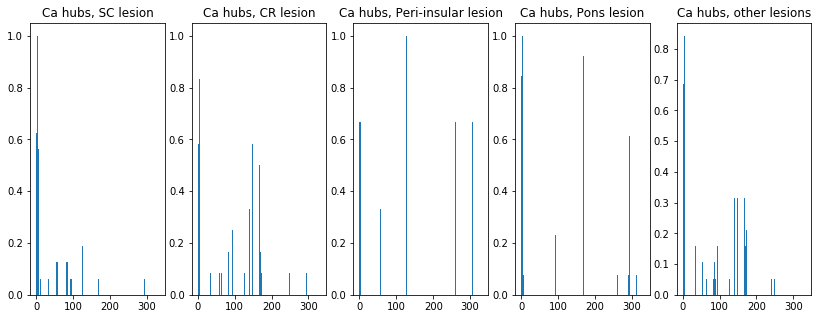

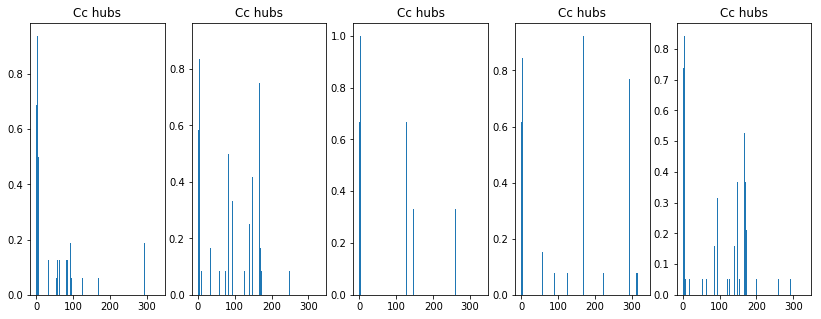

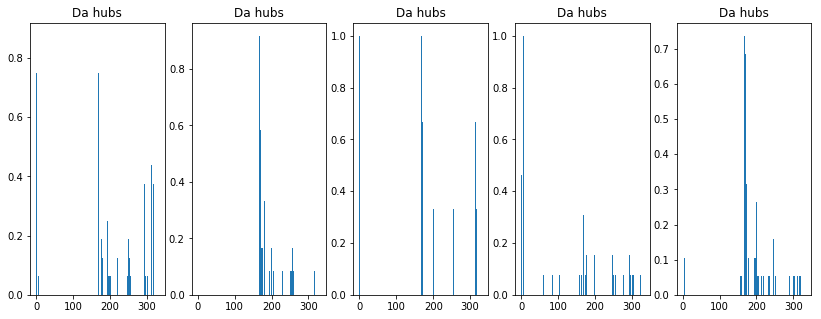

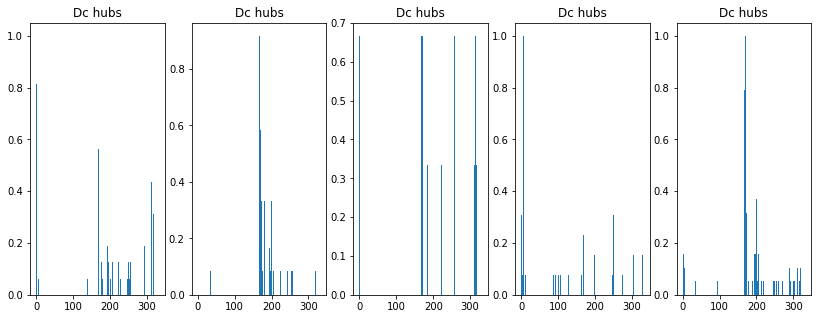

In [90]:
# What are the hubs in the dysconnectome and in the connectome?
# How do they change according to the lesion location?

#print(np.asarray(hubs_Ca)[SC_idx[0],0:5])
#print(np.asarray(hubs_Ca)[CR_idx[0],0:5])
#print(np.asarray(hubs_Ca)[pons_idx[0],0:5])
#print(np.asarray(hubs_Ca)[peri_idx[0],0:5])

fig, axs = plt.subplots(1,5, figsize=(14,5))
Ca_SC_h, Ca_SC_bin, _ = axs[0].hist(np.asarray(hubs_Ca)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Ca hubs, SC lesion')
Ca_CR_h, Ca_CR_bin, _ = axs[1].hist(np.asarray(hubs_Ca)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Ca hubs, CR lesion')
Ca_peri_h, Ca_peri_bin, _ = axs[2].hist(np.asarray(hubs_Ca)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Ca hubs, Peri-insular lesion')
Ca_pons_h, Ca_pons_bin, _ = axs[3].hist(np.asarray(hubs_Ca)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Ca hubs, Pons lesion')
Ca_all_h, Ca_all_bin, _ = axs[4].hist(np.asarray(hubs_Ca)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Ca hubs, other lesions')

fig, axs = plt.subplots(1,5, figsize=(14,5))
Cc_SC_h, Cc_SC_bin, _ = axs[0].hist(np.asarray(hubs_Cc)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Cc)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Cc hubs')
Cc_CR_h, Cc_CR_bin, _ = axs[1].hist(np.asarray(hubs_Cc)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Cc)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Cc hubs')
Cc_peri_h, Cc_peri_bin, _ = axs[2].hist(np.asarray(hubs_Cc)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Cc)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Cc hubs')
Cc_pons_h, Cc_pons_bin, _ = axs[3].hist(np.asarray(hubs_Cc)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Cc)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Cc hubs')
Cc_all_h, Cc_all_bin, _ = axs[4].hist(np.asarray(hubs_Cc)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Cc)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Cc hubs')

fig, axs = plt.subplots(1,5, figsize=(14,5))
Da_SC_h, Da_SC_bin, _ = axs[0].hist(np.asarray(hubs_Da)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Da)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Da hubs')
Da_CR_h, Da_CR_bin, _ = axs[1].hist(np.asarray(hubs_Da)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Da)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Da hubs')
Da_peri_h, Da_peri_bin, _ = axs[2].hist(np.asarray(hubs_Da)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Da)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Da hubs')
Da_pons_h, Da_pons_bin, _ = axs[3].hist(np.asarray(hubs_Da)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Da)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Da hubs')
Da_all_h, Da_all_bin, _ = axs[4].hist(np.asarray(hubs_Da)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Da)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Da hubs')

fig, axs = plt.subplots(1,5, figsize=(14,5))
Dc_SC_h, Dc_SC_bin, _ = axs[0].hist(np.asarray(hubs_Dc)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Dc)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Dc hubs')
Dc_CR_h, Dc_CR_bin, _ = axs[1].hist(np.asarray(hubs_Dc)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Dc)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Dc hubs')
Dc_peri_h, Dc_peri_bin, _ = axs[2].hist(np.asarray(hubs_Dc)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Dc)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Dc hubs')
Dc_pons_h, Dc_pons_bin, _ = axs[3].hist(np.asarray(hubs_Dc)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Dc)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Dc hubs')
Dc_all_h, Dc_all_bin, _ = axs[4].hist(np.asarray(hubs_Dc)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Dc)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Dc hubs')

-0.014285714285714284
0.053968253968253964


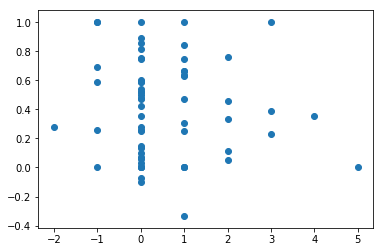

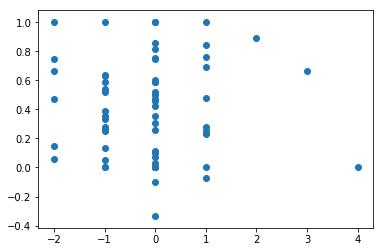

In [44]:
# Check the percentage of overlap of hubs in acute and chronic, dysconnectome and connectome. Will this be related to clinical improvement?
# Does higher percentage of hubs in unaff hemisphere leads to better recovery?
# Qualitatively, in time we have more hubs on the unaffaceted (and brain stem) side in the dysconnectomed. Are those subjects improving more?
# Would this work also the other way around? If connectome starts to switch hubs towards affected side, is it better connection?

# Connectome: count for each subject, how many hubs in controlateral
Ca_subject = []
for idx, hub in enumerate(hubs_Ca):
    count = np.size(np.where(np.asarray(hub)>167)[0])
    #if 0 in hub:
     #   count +=1
    Ca_subject.append(count)

Cc_subject = []
for idx, hub in enumerate(hubs_Cc):
    count = np.size(np.where(np.asarray(hub)>167)[0])
    #if 0 in hub:
     #   count +=1
    Cc_subject.append(count)

Da_subject = []
for idx, hub in enumerate(hubs_Da):
    count = np.size(np.where(np.asarray(hub)<167)[0])
    Da_subject.append(count)

Dc_subject = []
for idx, hub in enumerate(hubs_Dc):
    count = np.size(np.where(np.asarray(hub)<167)[0])
    Dc_subject.append(count)

D_subject = np.asarray(Dc_subject) - np.asarray(Da_subject)
C_subject = np.asarray(Cc_subject) - np.asarray(Ca_subject)
print(np.mean(C_subject/10))
print(np.mean(D_subject/10))

plt.figure()
plt.scatter(np.asarray(D_subject), df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(np.asarray(C_subject), df_clinical.iloc[:]['improvement'])

Having more hubs on the affected side in the connectome, does not relate with a better clinical improvment, nor does the opposite situation. Also a difference in hubs in the 2 hemispheres is not related to the clinical improvement.

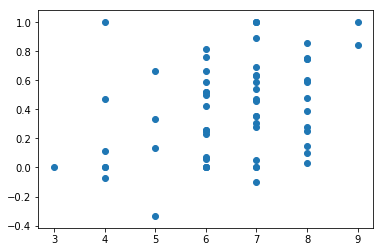

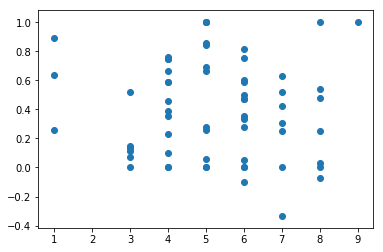

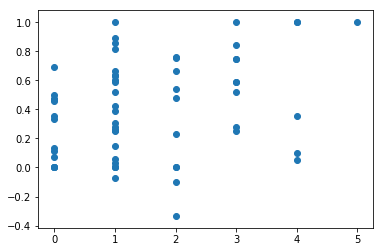

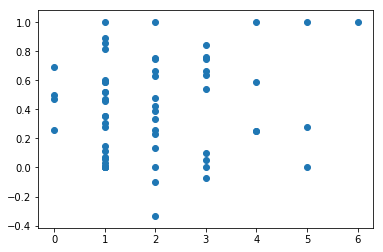

In [93]:
#How many hubs change for subject in connectome and dysconnectome?
overlap_conn = []
overlap_dysconn = []
overlap_DC_ta = []
overlap_DC_tc = []
for idx in range(len(subjects)-1):
    overlap_conn.append(len(set(hubs_Ca[idx]) & set(hubs_Cc[idx])))
    overlap_dysconn.append(len(set(hubs_Da[idx]) & set(hubs_Dc[idx])))
    overlap_DC_ta.append(len(set(hubs_Da[idx]) & set(hubs_Ca[idx])))
    overlap_DC_tc.append(len(set(hubs_Dc[idx]) & set(hubs_Cc[idx])))

plt.figure()
plt.scatter(np.asarray(overlap_conn)[:], df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(np.asarray(overlap_dysconn)[:], df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(np.asarray(overlap_DC_ta)[:], df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(np.asarray(overlap_DC_tc)[:], df_clinical.iloc[:]['improvement'])

There is no correlation between the overlap of hubs in time (in connectome or dysconnectome), nor considering an overlap of hubs between connectome and dysconnectome in the same time point.

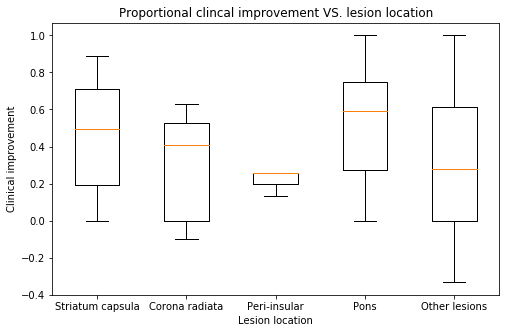

In [277]:
df_clinical = pd.read_csv('clinical.csv', delimiter=';')

# fake up some more data
SC = df_clinical.iloc[SC_idx]['improvement']
CR = df_clinical.iloc[CR_idx]['improvement']
periinsular = df_clinical.iloc[peri_idx]['improvement']
Pons = df_clinical.iloc[pons_idx]['improvement']
Others = df_clinical.iloc[others_idx]['improvement']

data = [list(SC), list(CR), list(periinsular), list(Pons), list(Others)]
# Multiple box plots on one Axes
fig, ax = plt.subplots(figsize = (8,5))
ax.boxplot(data)
ax.set_xticklabels(['Striatum capsula', 'Corona radiata', 'Peri-insular', 'Pons', 'Other lesions'])
ax.set_ylabel('Clinical improvement')
ax.set_xlabel('Lesion location')
ax.set_title('Proportional clincal improvement VS. lesion location')
plt.show()

#NB: change in degree (at least dysconnectome) is the same for all subject groups

Qualitatively, it would seem that subjects with Pons lesion have a better improvement clinically.

In [99]:
pons_SC_stat, pons_SC_pval = scipy.stats.ranksums(SC, Pons)
pons_others_stat, pons_others_pval = scipy.stats.ranksums(Others, Pons)
pons_CR_stat, pons_CR_pval = scipy.stats.ranksums(CR, Pons)
pons_peri_stat, pons_peri_pval = scipy.stats.ranksums(periinsular, Pons)

SC_CR_stat, SC_CR_pval = scipy.stats.ranksums(SC, CR)
SC_peri_stat, SC_peri_pval = scipy.stats.ranksums(SC, periinsular)
SC_others_stat, SC_others_pval = scipy.stats.ranksums(SC, Others)

CR_peri_stat, CR_peri_pval = scipy.stats.ranksums(periinsular, CR)
CR_others_stat, CR_others_pval = scipy.stats.ranksums(Others, CR)

peri_others_stat, peri_others_pval = scipy.stats.ranksums(periinsular, Others)

print(pons_CR_stat, pons_CR_pval)

-1.7677669529663689 0.0770998717435417


There is a statistical difference only when comparinc CR lesion and Pons lesion

Max differences across all subjects
Series([], Name: Areaname, dtype: object)
1    rh_Thalamus
3     rh_Putamen
4    rh_Pallidum
Name: Areaname, dtype: object





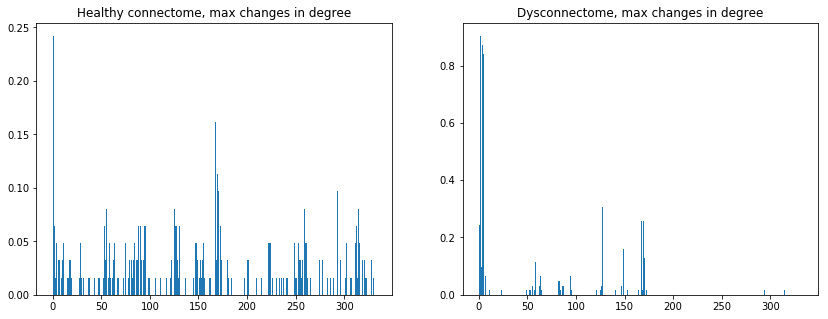

In [20]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
print('Max differences across all subjects')
ind = []
for idx in range(62):
    ind = ind+(list(np.argpartition(diff_unaff_avg_deg[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[0].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/62)
axs[0].set_title('Healthy connectome, max changes in degree')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])

ind = []
for idx in range(62):
    ind = ind+(list(np.argpartition(diff_aff_avg_deg[:,idx], -5)[-5:]))
bin_heights_c, bin_borders_c, _ = axs[1].hist(np.asarray(ind),bins=np.linspace(0,332,333),weights=np.ones_like(ind)/62)
axs[1].set_title('Dysconnectome, max changes in degree')
print(coordinates.iloc[np.nonzero(bin_heights_c>0.5)*1]['Areaname'])
print('\n\n')

In [225]:
# Compute, for each subject, the number of new conections that we are creating and the number of lost connections
new_D = []
lost_D =[]
new_C =[]
lost_C = []
for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1
        
        new_C.append(np.size(np.where((Cc_bin-Ca_bin)>0)))
        lost_C.append(np.size(np.where((Cc_bin-Ca_bin)<0)))
        new_D.append(np.size(np.where((Dc_bin-Da_bin)>0)))
        lost_D.append(np.size(np.where((Dc_bin-Da_bin)<0)))
    


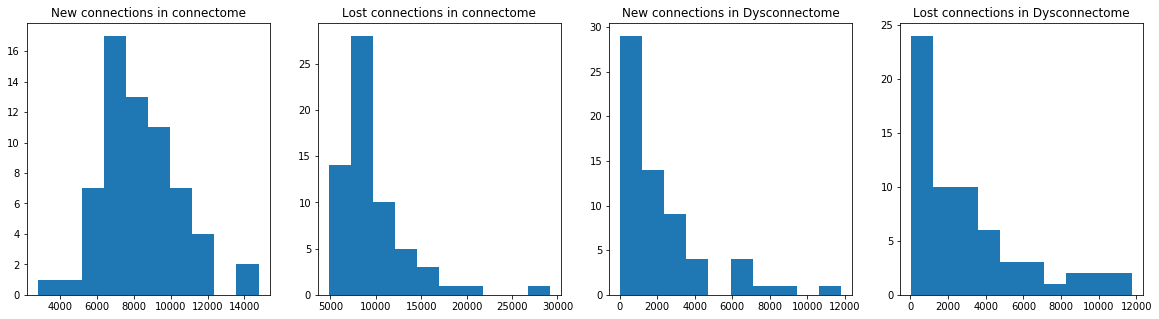

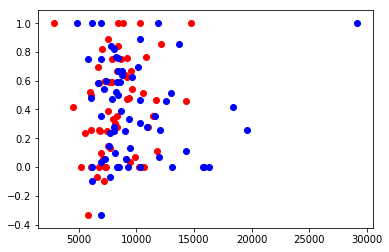

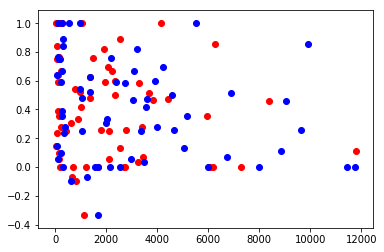

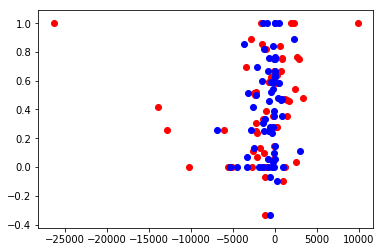

In [226]:
# plt histogram
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs[0].hist(new_C)
axs[0].set_title('New connections in connectome')
axs[1].hist(lost_C)
axs[1].set_title('Lost connections in connectome')
axs[2].hist(new_D)
axs[2].set_title('New connections in Dysconnectome')
axs[3].hist(lost_D)
axs[3].set_title('Lost connections in Dysconnectome')


# plt new connections vs clinical score, plot lost connections vs clinical score
plt.figure()
import matplotlib.cm as cm
data = [new_C, lost_C, new_D, lost_D]
colors = cm.rainbow(np.linspace(0, 1, len(data)))
colors = ["r", "b"]
for idx in range(2):
    plt.scatter(data[idx], list(df_clinical.iloc[:]['improvement']), color=colors[idx])

plt.figure()
for idx in range(2):
    plt.scatter(data[idx+2], list(df_clinical.iloc[:]['improvement']), color=colors[idx])


# plt clincal score over net new connections
data = [list(np.asarray(new_C)-np.asarray(lost_C)), list(np.asarray(new_D)-np.asarray(lost_D))]
plt.figure()
for idx in range(2):
    plt.scatter(data[idx], list(df_clinical.iloc[:]['improvement']), color=colors[idx])



In [232]:
print(np.sum(np.nonzero(acute_unaff_deg_norm)))
print((np.sum(new_C) -np.sum(lost_C))/np.sum(np.nonzero(acute_unaff_deg_norm)))
print((np.sum(new_D)-np.sum(lost_D))/np.sum(np.nonzero(acute_aff_deg_norm)))

4064908
-0.0224979261523262
-0.01752290574847224


Plot the different connectomes we are using as an example

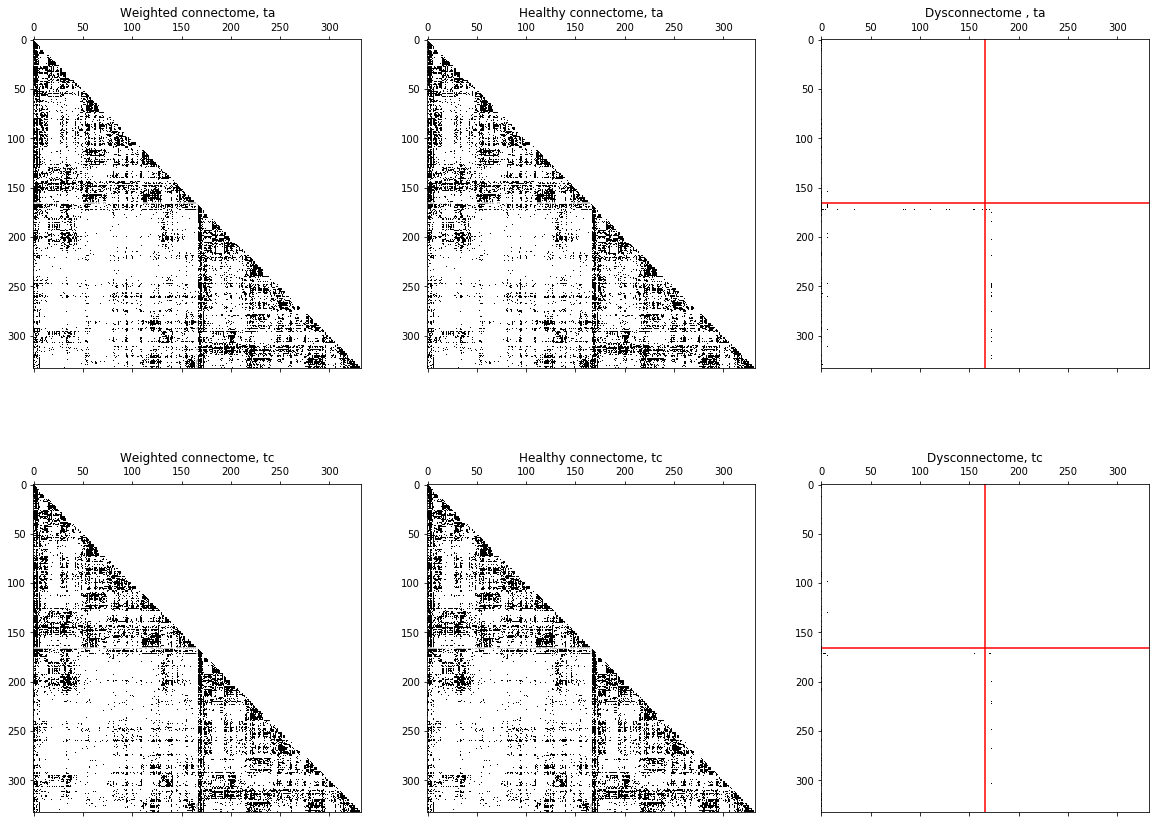

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20,15))
#axes[0,0].imshow(Ca, cmap='gray_r')
ax0 = axes[0, 0]
ax0.spy(Ca)
axes[0,0].set_title('Weighted connectome, ta')
axes[0,0].axvline(np.shape(Ca_healthy)[0] // 2, c='w')
axes[0,0].axhline(np.shape(Ca_healthy)[0] // 2, c='w')

ax1 = axes[0, 1]
ax1.spy(Ca_healthy)
axes[0,1].set_title('Healthy connectome, ta')
axes[0,2].axvline(np.shape(Ca_healthy)[0] // 2, c='w')
axes[0,1].axhline(np.shape(Ca_healthy)[0] // 2, c='w')
#axes[0,1].imshow(Da, cmap='gray_r')
ax2 = axes[0, 2]
ax2.spy(Da_FA)
axes[0,2].set_title('Dysconnectome , ta')
axes[0,2].axvline(np.shape(Ca_healthy)[0] // 2, c='r')
axes[0,2].axhline(np.shape(Ca_healthy)[0] // 2, c='r')
#axes[1,0].imshow(Cc, cmap='jet')
ax3 = axes[1, 0]
ax3.spy(Cc)
axes[1,0].set_title('Weighted connectome, tc')
axes[1,0].axvline(np.shape(Ca_healthy)[0] // 2, c='w')
axes[1,0].axhline(np.shape(Ca_healthy)[0] // 2, c='w')

ax4 = axes[1, 1]
ax4.spy(Cc_healthy)
axes[1,1].set_title('Healthy connectome, tc')
axes[1,1].axvline(np.shape(Ca_healthy)[0] // 2, c='w')
axes[1,1].axhline(np.shape(Ca_healthy)[0] // 2, c='w')
#axes[1,1].imshow(Dc, cmap='gray_r')
ax5 = axes[1, 2]
ax5.spy(Dc_FA)
axes[1,2].set_title('Dysconnectome, tc')
axes[1,2].axvline(np.shape(Ca_healthy)[0] // 2, c='r')
axes[1,2].axhline(np.shape(Ca_healthy)[0] // 2, c='r')

## Topological features
Compute clustering coefficient, find the 5 biggest hubs (and how many edges they have)

In [40]:
SWIs_Da = []
SWIs_Dc = []
SWIs_Ca = []
SWIs_Cc = []

efficiencies_Da =[]
efficiencies_Dc =[]
efficiencies_Ca =[]
efficiencies_Cc =[]

for subject in subjects:
    if os.path.isdir('Data_Dysconnectome/'+subject):
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1
        # create new dysconnectomes (with FA values)
        Da_FA = np.multiply(Ca,Da_bin)
        Dc_FA = np.multiply(Cc,Dc_bin)
        # create healthy connectomes
        Ca_healthy = np.multiply((Ca_bin - Da_bin), Ca)
        Cc_healthy = np.multiply((Cc_bin - Dc_bin), Cc)
        
        G_Da = nx.from_numpy_array(Da_FA)
        G_Dc = nx.from_numpy_array(Dc_FA)
        G_Ca = nx.from_numpy_array(Ca_healthy)
        G_Cc = nx.from_numpy_array(Cc_healthy)
        
        # efficiency
        G_Da_connected = max(nx.connected_component_subgraphs(G_Da), key=len)
        G_Dc_connected = max(nx.connected_component_subgraphs(G_Dc), key=len)
        G_Ca_connected = max(nx.connected_component_subgraphs(G_Ca), key=len)
        G_Cc_connected = max(nx.connected_component_subgraphs(G_Cc), key=len)
        
        efficiency = nx.global_efficiency(G_Da_connected)
        efficiencies_Da.append(efficiency)
        efficiency = nx.global_efficiency(G_Dc_connected)
        efficiencies_Dc.append(efficiency)
        efficiency = nx.global_efficiency(G_Ca_connected)
        efficiencies_Ca.append(efficiency)
        efficiency = nx.global_efficiency(G_Cc_connected)
        efficiencies_Cc.append(efficiency)

        # SWI
        n_nodes = len(G_Da_connected)
        n_edges = len(np.nonzero(Da)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Da_connected))
        L = nx.average_shortest_path_length(G_Da_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Da.append(swi)
        
        n_nodes = len(G_Dc_connected)
        n_edges = len(np.nonzero(Dc)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Dc_connected))
        L = nx.average_shortest_path_length(G_Dc_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Dc.append(swi)
        
        n_nodes = len(G_Ca_connected)
        n_edges = len(np.nonzero(Ca)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Ca_connected))
        L = nx.average_shortest_path_length(G_Ca_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Ca.append(swi)
        
        n_nodes = len(G_Cc_connected)
        n_edges = len(np.nonzero(Cc)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Cc_connected))
        L = nx.average_shortest_path_length(G_Cc_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Cc.append(swi)
        

In [41]:
np.save('SWI_Da.npy', SWIs_Da)
np.save('SWI_Dc.npy', SWIs_Dc)
np.save('SWI_Ca.npy', SWIs_Ca)
np.save('SWI_Cc.npy', SWIs_Cc)
np.save('eff_Da.npy', efficiencies_Da)
np.save('eff_Dc.npy', efficiencies_Dc)
np.save('eff_Ca.npy', efficiencies_Ca)
np.save('eff_Cc.npy', efficiencies_Cc)

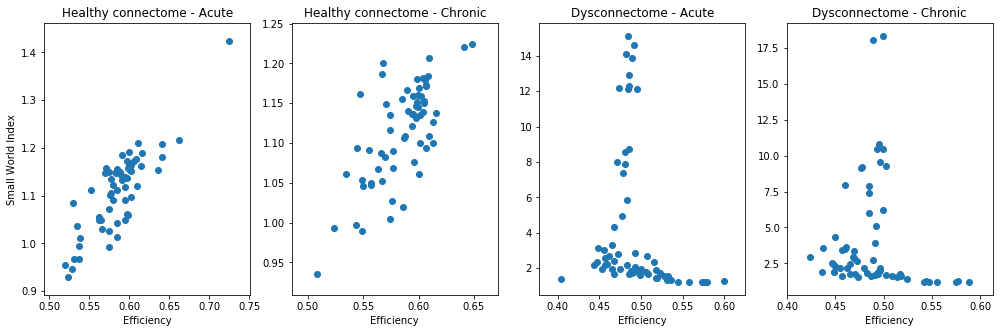

In [271]:
SWIs_Da = np.load('SWI_Da.npy')
SWIs_Dc = np.load('SWI_Dc.npy')
SWIs_Ca = np.load('SWI_Ca.npy')
SWIs_Cc = np.load('SWI_Cc.npy')
efficiencies_Da = np.load('eff_Da.npy') 
efficiencies_Dc = np.load('eff_Dc.npy') 
efficiencies_Ca = np.load('eff_Ca.npy') 
efficiencies_Cc = np.load('eff_Cc.npy') 

fig, ax = plt.subplots(1,4,figsize=(17,5))

ax[0].scatter(efficiencies_Ca, SWIs_Ca)
ax[0].set_xlabel('Efficiency')
ax[0].set_ylabel('Small World Index')
ax[0].set_title('Healthy connectome - Acute')
ax[1].scatter(efficiencies_Cc, SWIs_Cc)
ax[1].set_xlabel('Efficiency')
#ax[1].set_ylabel('Small World Index')
ax[1].set_title('Healthy connectome - Chronic')
ax[2].scatter(efficiencies_Da, SWIs_Da)
ax[2].set_xlabel('Efficiency')
#ax[2].set_ylabel('Small World Index')
ax[2].set_title('Dysconnectome - Acute')
ax[3].scatter(efficiencies_Dc, SWIs_Dc)
ax[3].set_xlabel('Efficiency')
#ax[3].set_ylabel('Small World Index')
ax[3].set_title('Dysconnectome - Chronic')

x = efficiencies_Da
y = SWIs_Da
b, m = np.polynomial.polynomial.polyfit(y, x, 1)

#plt.plot(x, y, '.')
#ax[2].plot(x, b + m * x, '-')
#plt.show(

Text(0.5, 1.0, 'Dysconnectome - Acute')

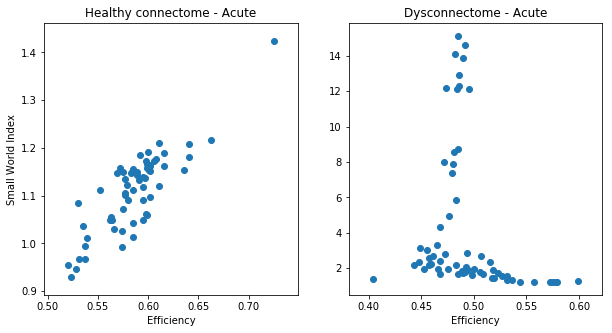

In [273]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(efficiencies_Ca, SWIs_Ca)
ax[0].set_xlabel('Efficiency')
ax[0].set_ylabel('Small World Index')
ax[0].set_title('Healthy connectome - Acute')
ax[1].scatter(efficiencies_Da, SWIs_Da)
ax[1].set_xlabel('Efficiency')
#ax[2].set_ylabel('Small World Index')
ax[1].set_title('Dysconnectome - Acute')


0.49280924569230766
0.33492602227027024


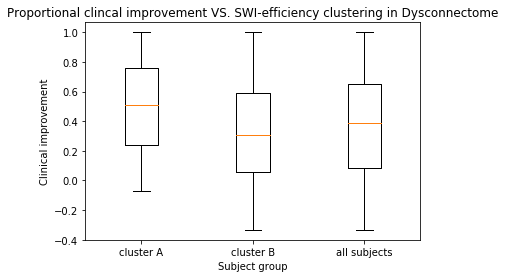

0      Pons
2       CR 
6        CR
7      Pons
8        TH
11      SC 
14     Pons
15    Pons 
16     Pons
19       CR
22     Pons
25     Pons
29       SC
34       CR
35       SC
40       CR
43     Pons
45     Pons
47       CR
48    Rt CR
51     Pons
52     Pons
53    Pons 
54     Pons
55     Pons
62     Pons
Name: location, dtype: object

In [131]:
# Divide into clusters from the dysconnectome swi-efficiency graphs
clust_A = []
clust_B = []
for idx, swi in enumerate(SWIs_Da):
    if swi >= SWIs_Da[29] + ((efficiencies_Da[idx]-efficiencies_Da[29])*(SWIs_Da[2]-SWIs_Da[29]))/(efficiencies_Da[2]-efficiencies_Da[29]):
        clust_A.append(idx)
    else:
        clust_B.append(idx)
            
#print(SWIs_Da[29], efficiencies_Da[29])
#print(SWIs_Da[2], efficiencies_Da[2])

print(np.mean(df_clinical.iloc[clust_A]['improvement']))
print(np.mean(df_clinical.iloc[clust_B]['improvement']))
clust_A_acu = clust_A
#fig, ax = plt.subplots(1,2,figsize=(17,5))
#ax[0].hist(df_clinical.iloc[clust_A]['improvement'])
#ax[1].hist(df_clinical.iloc[clust_B]['improvement'])

data = [list(df_clinical.iloc[clust_A]['improvement']), list(df_clinical.iloc[clust_B]['improvement']), list(df_clinical.iloc[:]['improvement'])]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['cluster A', 'cluster B','all subjects'])
ax.set_ylabel('Clinical improvement')
ax.set_xlabel('Subject group')
ax.set_title('Proportional clincal improvement VS. SWI-efficiency clustering in Dysconnectome')
plt.show()

lesion_loc_df.iloc[clust_A]['location']

(array([ 2, 11, 19, 24, 40, 46, 48, 56, 61]),)
(array([ 1,  3,  4,  5, 10, 12, 13, 17, 18, 20, 21, 23, 24, 27, 28, 29, 30,
       32, 33, 36, 37, 38, 39, 40, 41, 42, 44, 48, 49, 50, 56, 57, 59, 60,
       61]),)
0.4393325579210526
0.34042664044000004


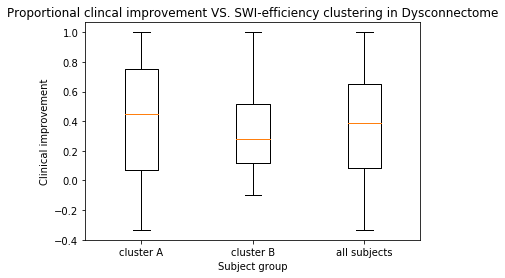

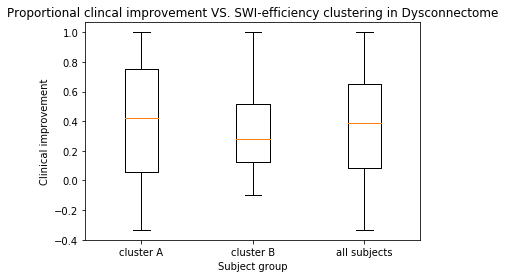

0        Pons
2         CR 
6          CR
7        Pons
8          TH
9         SC 
11        SC 
14       Pons
15      Pons 
16       Pons
18         SC
19         CR
21         SC
22       Pons
24         SC
25       Pons
26    Medulla
29         SC
31         SC
34         CR
35         SC
37         SC
40         CR
41         BG
43       Pons
45       Pons
46         CR
47         CR
48      Rt CR
51       Pons
52       Pons
53      Pons 
54       Pons
55       Pons
58         CR
59       CRSC
61         SC
62       Pons
Name: location, dtype: object

In [133]:
# Divide into clusters from the dysconnectome swi-efficiency graphs
clust_A = []
clust_B = []
for idx, swi in enumerate(SWIs_Dc):
    if swi >= SWIs_Dc[48] + ((efficiencies_Dc[idx]-efficiencies_Dc[48])*(SWIs_Dc[40]-SWIs_Dc[48]))/(efficiencies_Dc[40]-efficiencies_Dc[48]):
        clust_A.append(idx)
    else:
        clust_B.append(idx)

print(np.where(np.asarray(efficiencies_Dc)<0.45))
print(np.where(np.asarray(SWIs_Dc)<2.5))
#print(SWIs_Dc[24], efficiencies_Dc[24])
#print(SWIs_Dc[40], efficiencies_Dc[40])
#print(SWIs_Dc[48], efficiencies_Dc[48])
#print(SWIs_Dc[56], efficiencies_Dc[56])
#print(SWIs_Dc[61], efficiencies_Dc[61])

print(np.mean(df_clinical.iloc[clust_A]['improvement']))
print(np.mean(df_clinical.iloc[clust_B]['improvement']))

#fig, ax = plt.subplots(1,2,figsize=(17,5))
#ax[0].hist(df_clinical.iloc[clust_A]['improvement'])
#ax[1].hist(df_clinical.iloc[clust_B]['improvement'])

data = [list(df_clinical.iloc[clust_A]['improvement']), list(df_clinical.iloc[clust_B]['improvement']), list(df_clinical.iloc[:]['improvement'])]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['cluster A', 'cluster B','all subjects'])
ax.set_ylabel('Clinical improvement')
ax.set_xlabel('Subject group')
ax.set_title('Proportional clincal improvement VS. SWI-efficiency clustering in Dysconnectome')
plt.show()

clust_A_chr = np.copy(clust_A)
# try with slightly different separating line
clusclust_B = []
for idx, swi in enumerate(SWIs_Dc):
    if swi >= SWIs_Dc[48] + ((efficiencies_Dc[idx]-efficiencies_Dc[48])*(SWIs_Dc[56]-SWIs_Dc[48]))/(efficiencies_Dc[56]-efficiencies_Dc[48]):
        clust_A.append(idx)
    else:
        clust_B.append(idx)
data = [list(df_clinical.iloc[clust_A]['improvement']), list(df_clinical.iloc[clust_B]['improvement']), list(df_clinical.iloc[:]['improvement'])]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['cluster A', 'cluster B','all subjects'])
ax.set_ylabel('Clinical improvement')
ax.set_xlabel('Subject group')
ax.set_title('Proportional clincal improvement VS. SWI-efficiency clustering in Dysconnectome')
plt.show()

lesion_loc_df.iloc[clust_A_chr]['location']


25
26
38
[9, 18, 21, 24, 26, 31, 37, 41, 46, 58, 59, 61]


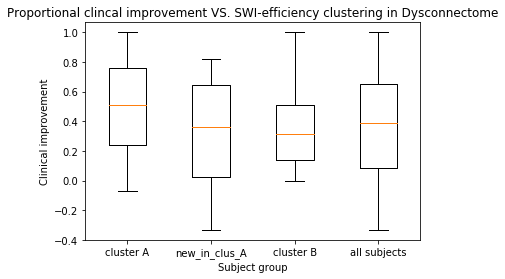

In [126]:
remained = []
lost = []
new = []
for i in range(62):
    if i in clust_A_chr:
        if i in clust_A_acu:
            remained.append(i)
        else:
            new.append(i)
print(len(remained))
print(len(clust_A_acu))
print(len(clust_A_chr))
print(new)


clust_A_n = []
clust_B_n = clust_B + new
data = [list(df_clinical.iloc[clust_A_acu]['improvement']), list(df_clinical.iloc[new]['improvement']), list(df_clinical.iloc[clust_B]['improvement']), list(df_clinical.iloc[:]['improvement'])]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['cluster A', 'new_in_clus_A', 'cluster B','all subjects'])
ax.set_ylabel('Clinical improvement')
ax.set_xlabel('Subject group')
ax.set_title('Proportional clincal improvement VS. SWI-efficiency clustering in Dysconnectome')
plt.show()



-0.010071735409812885 0.04474395721484474
-0.006867436087536667 0.022341868272991377
-0.22468837618808515 2.622417040702436
-0.006528940329501362 0.018143739535698603


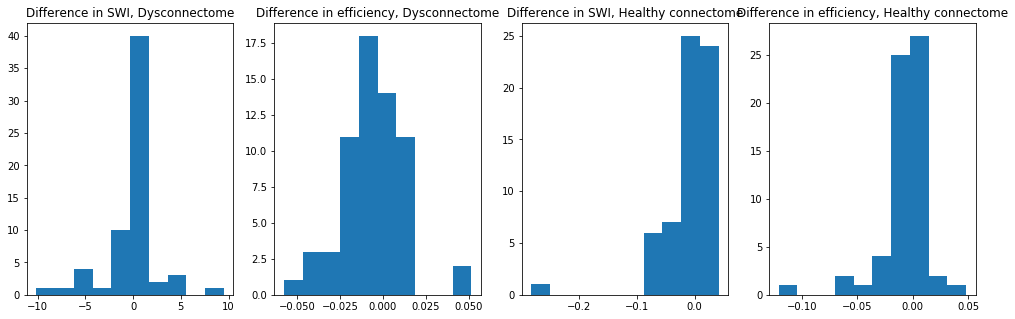

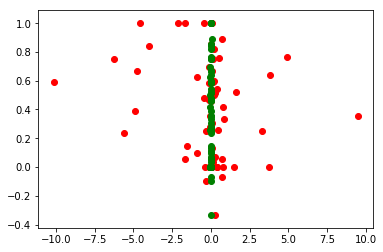

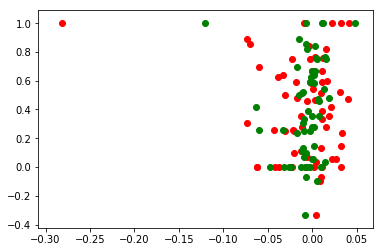

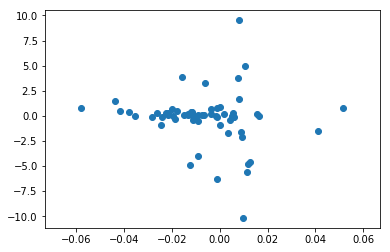

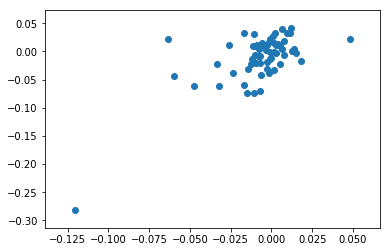

In [237]:
# are there differences from chronic to acute? for which subjects?
SWIs_D = np.asarray(SWIs_Dc)-np.asarray(SWIs_Da)
SWIs_C = np.asarray(SWIs_Cc)-np.asarray(SWIs_Ca)
eff_C = np.asarray(efficiencies_Cc) - np.asarray(efficiencies_Ca)
eff_D = np.asarray(efficiencies_Dc) - np.asarray(efficiencies_Da)

print(np.mean(SWIs_C), np.std(SWIs_C))
print(np.mean(eff_C), np.std(eff_C))
print(np.mean(SWIs_D), np.std(SWIs_D))
print(np.mean(eff_D), np.std(eff_D))


fig, ax = plt.subplots(1,4,figsize=(17,5))
ax[0].hist(SWIs_D)
ax[0].set_title('Difference in SWI, Dysconnectome')
ax[1].hist(eff_D)
ax[1].set_title('Difference in efficiency, Dysconnectome')
ax[2].hist(SWIs_C)
ax[2].set_title('Difference in SWI, Healthy connectome')
ax[3].hist(eff_C)
ax[3].set_title('Difference in efficiency, Healthy connectome')

# plot clinical score over change in SWI and efficiency
data = [list(SWIs_D), list(eff_D), list(SWIs_C), list(eff_C)]
colors = ['red', 'green']
plt.figure()
for idx in range(2):
    plt.scatter(data[idx], list(df_clinical.iloc[:]['improvement']), color=colors[idx])
plt.figure()
for idx in range(2):
    plt.scatter(data[idx+2], list(df_clinical.iloc[:]['improvement']), color=colors[idx])

plt.figure()
plt.scatter(eff_D, SWIs_D)
plt.figure()
plt.scatter(eff_C, SWIs_C)

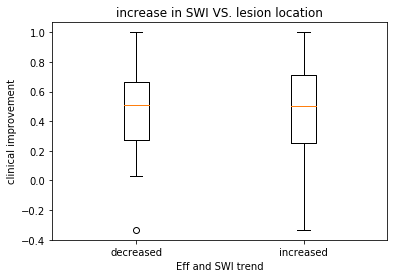

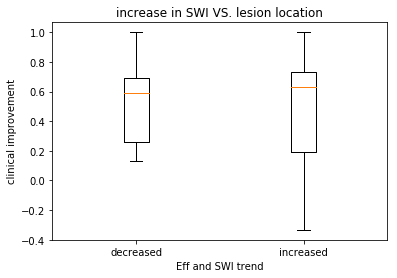

RanksumsResult(statistic=-0.08522233187259295, pvalue=0.9320846368977735)

In [115]:
# Check if a negative change in eff and swi relates to poorer improvement:
decr_C_idx = (list((np.where(SWIs_C[list(np.where(eff_C<0)[0])]<0))[0]))
incr_C_idx = (list((np.where(SWIs_C[list(np.where(eff_C>=0)[0])]>=0))[0]))

data = [df_clinical.iloc[decr_C_idx]['improvement'], df_clinical.iloc[incr_C_idx]['improvement'] ]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['decreased', 'increased'])
ax.set_ylabel('clinical improvement')
ax.set_xlabel('Eff and SWI trend')
ax.set_title('increase in SWI VS. lesion location')
plt.show()


decr_D_idx = (list((np.where(SWIs_D[list(np.where(eff_D<0)[0])]<0))[0]))
incr_D_idx = (list((np.where(SWIs_D[list(np.where(eff_D>=0)[0])]>=0))[0]))

data = [df_clinical.iloc[decr_D_idx]['improvement'], df_clinical.iloc[incr_D_idx]['improvement'] ]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['decreased', 'increased'])
ax.set_ylabel('clinical improvement')
ax.set_xlabel('Eff and SWI trend')
ax.set_title('increase in SWI VS. lesion location')
plt.show()

scipy.stats.ranksums(df_clinical.iloc[decr_C_idx]['improvement'], df_clinical.iloc[incr_C_idx]['improvement'])

The differences are not significant

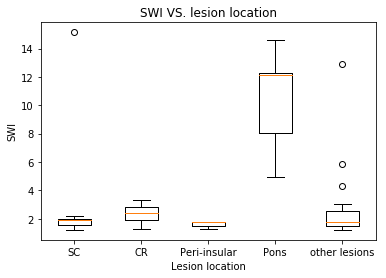

In [116]:
# plot SWI related to the lesion 
data = [np.asarray(SWIs_Da)[SC_idx[0]], np.asarray(SWIs_Da)[CR_idx[0]], np.asarray(SWIs_Da)[peri_idx[0]], np.asarray(SWIs_Da)[pons_idx[0]], np.asarray(SWIs_Da)[others_idx]]
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['SC', 'CR', 'Peri-insular', 'Pons', 'other lesions'])
ax.set_ylabel('SWI')
ax.set_xlabel('Lesion location')
ax.set_title('SWI VS. lesion location')
plt.show()

**Density of connectomes/dysconnectomes for each subject**

In [56]:
density_Ca = []
density_Cc = []
density_Da = []
density_Dc = []
# Go through the different subjects:
for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1

        # create new dysconnectomes (with FA values)
        Da_FA = np.multiply(Ca,Da_bin)
        Dc_FA = np.multiply(Cc,Dc_bin)
        
        Da_FA_bin = (Da_FA>0)*1
        Dc_FA_bin = (Dc_FA>0)*1
        
        # create healthy connectomes
        Ca_healthy = np.multiply((Ca_bin - Da_bin), Ca)
        Cc_healthy = np.multiply((Cc_bin - Dc_bin), Cc)
        Ca_healthy_bin = Ca_bin - Da_bin
        Cc_healthy_bin = Cc_bin - Dc_bin
        
        density_Ca.append(2*np.count_nonzero(Ca_bin)/(len(Ca)*(len(Ca)-1)))
        density_Cc.append(2*np.count_nonzero(Cc_bin)/(len(Cc)*(len(Cc)-1)))
        
        nodes_Da =len(np.unique(list(np.nonzero(Da)[0])+list(np.nonzero(Da)[1])))
        nodes_Dc =len(np.unique(list(np.nonzero(Dc)[0])+list(np.nonzero(Dc)[1])))
        density_Da.append(2*np.count_nonzero(Da_bin)/(nodes_Da*(nodes_Da-1)))
        density_Dc.append(2*np.count_nonzero(Dc_bin)/(nodes_Dc*(nodes_Dc-1)))

(array([ 1.,  2.,  1.,  4.,  7., 10., 23., 12.,  1.,  2.]),
 array([-5.78547027e-02, -4.95977345e-02, -4.13407663e-02, -3.30837982e-02,
        -2.48268300e-02, -1.65698618e-02, -8.31289364e-03, -5.59254594e-05,
         8.20104272e-03,  1.64580109e-02,  2.47149791e-02]),
 <a list of 10 Patch objects>)

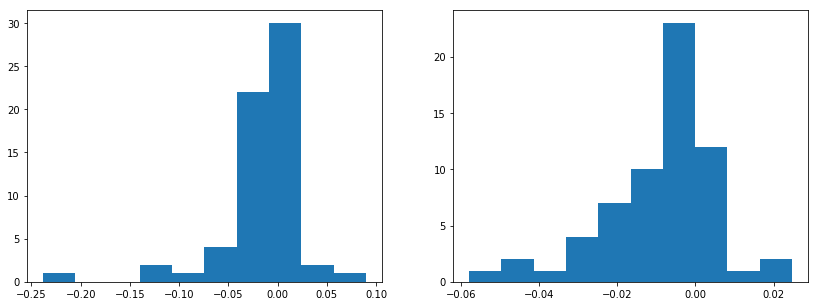

In [67]:
density_C = np.asarray(density_Cc)-np.asarray(density_Ca)
density_D = np.asarray(density_Dc)-np.asarray(density_Da)
fig, axs= plt.subplots(1,2, figsize=(14,5))
axs[0].hist(density_C)
axs[1].hist(density_D)

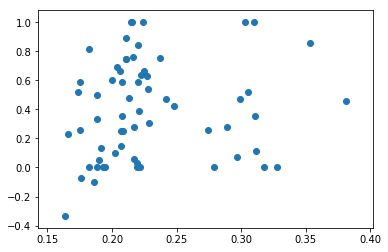

In [72]:
plt.scatter(density_Cc, list(df_clinical.iloc[:]['improvement']))

From full connectome to healthy connectome

In [254]:
# do changes occur in the hubs or not?
# count the occurence of hubs, choose the biggest. What is the average change there, what is the fraction compared to 
# to the total change?
hubs_Ca_f = []
hubs_Cc_f = []
hubs_Da_f = []
hubs_Dc_f = []

hubs_Ca_h = []
hubs_Cc_h = []
hubs_Da_h = []
hubs_Dc_h = []

density_Ca_f = []
density_Cc_f = []
density_Ca_h = []
density_Cc_h = []

acute_avg_deg_f = []
chronic_avg_deg_f = []

acute_avg_deg_h = []
chronic_avg_deg_h = []

acute_avg_deg_d = []
chronic_avg_deg_d = []

acute_deg_f = np.zeros((333, len(subjects)-1))
chronic_deg_f = np.zeros((333, len(subjects)-1))

acute_deg_h = np.zeros((333, len(subjects)-1))
chronic_deg_h = np.zeros((333, len(subjects)-1))


for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1

        
        # create healthy connectomes
        Ca_healthy = np.multiply((Ca_bin - Da_bin), Ca)
        Cc_healthy = np.multiply((Cc_bin - Dc_bin), Cc)
        Ca_healthy_norm = Ca_healthy/np.max(Ca_healthy)
        Cc_healthy_norm = Cc_healthy/np.max(Cc_healthy)
        
        # get the degree of the new connectomes
        Ca_healthy_t = np.transpose(Ca_healthy_norm)
        degree_Ca_h = np.sum(Ca_healthy_norm + Ca_healthy_t, axis=0) 
        Cc_healthy_t = np.transpose(Cc_healthy_norm)
        degree_Cc_h = np.sum(Cc_healthy_norm + Cc_healthy_t, axis=0) 
        
        Da_t = np.transpose(Da)
        degree_Da = np.sum(Da + Da_t, axis=0)
        Dc_t = np.transpose(Dc)
        degree_Dc = np.sum(Dc + Dc_t, axis=0)
        
        Ca_t = np.transpose(Ca)
        degree_Ca_f = np.sum(Ca + Ca_t, axis=0) 
        Cc_t = np.transpose(Cc)
        degree_Cc_f = np.sum(Cc + Cc, axis=0) 
        
        
        acute_deg_h[:,idx-1] = degree_Ca_h
        chronic_deg_h[:,idx-1] = degree_Cc_h
        
        acute_deg_f[:,idx-1] = degree_Ca_f
        chronic_deg_f[:,idx-1] = degree_Cc_f
        
        acute_avg_deg_h.append(np.mean(degree_Ca_h))
        chronic_avg_deg_h.append(np.mean(degree_Cc_h))
        
        acute_avg_deg_d.append(np.mean(degree_Da))
        chronic_avg_deg_d.append(np.mean(degree_Dc))
        
        acute_avg_deg_f.append(np.mean(degree_Ca_f))
        chronic_avg_deg_f.append(np.mean(degree_Cc_f))
         
        # find 15 biggest hubs
        hubs_Ca_h.append(list(np.unravel_index(np.argsort(degree_Ca_h, axis=None), degree_Ca_h.shape)[0][-11:-1]))
        hubs_Cc_h.append(list(np.unravel_index(np.argsort(degree_Cc_h, axis=None), degree_Cc_h.shape)[0][-11:-1]))
        hubs_Ca_f.append(list(np.unravel_index(np.argsort(degree_Ca_f, axis=None), degree_Ca_f.shape)[0][-11:-1]))
        hubs_Cc_f.append(list(np.unravel_index(np.argsort(degree_Cc_f, axis=None), degree_Cc_f.shape)[0][-11:-1]))
        
        density_Ca_f.append(2*np.count_nonzero(Ca_bin)/(len(Ca)*(len(Ca)-1)))
        density_Cc_f.append(2*np.count_nonzero(Cc_bin)/(len(Cc)*(len(Cc)-1)))
        density_Ca_h.append(2*np.count_nonzero(Ca_healthy)/(len(Ca_healthy)*(len(Ca_healthy)-1)))
        density_Cc_h.append(2*np.count_nonzero(Cc_healthy)/(len(Cc_healthy)*(len(Cc_healthy)-1)))
        

In [131]:
# compute SWI and efficiency for the full connectome
SWIs_Ca = []
SWIs_Cc = []

efficiencies_Ca =[]
efficiencies_Cc =[]

for subject in subjects:
    if os.path.isdir('Data_Dysconnectome/'+subject):
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Cc, 0)
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Cc_bin = (Cc > 0)*1
        
        G_Ca = nx.from_numpy_array(Ca)
        G_Cc = nx.from_numpy_array(Cc)
        
        # efficiency
        G_Ca_connected = max(nx.connected_component_subgraphs(G_Ca), key=len)
        G_Cc_connected = max(nx.connected_component_subgraphs(G_Cc), key=len)

        efficiency = nx.global_efficiency(G_Ca_connected)
        efficiencies_Ca.append(efficiency)
        efficiency = nx.global_efficiency(G_Cc_connected)
        efficiencies_Cc.append(efficiency)

        # SWI
        n_nodes = len(G_Ca_connected)
        n_edges = len(np.nonzero(Ca)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Ca_connected))
        L = nx.average_shortest_path_length(G_Ca_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Ca.append(swi)
        
        n_nodes = len(G_Cc_connected)
        n_edges = len(np.nonzero(Cc)[0])
        density = n_edges/((n_nodes * (n_nodes - 1))/2)  # Network density (Sparsity)
        m =  int(n_nodes*density)
        if m<2:
            m=2
        G_pc = nx.powerlaw_cluster_graph(n_nodes, m , nx.average_clustering(G_Cc_connected))
        L = nx.average_shortest_path_length(G_Cc_connected)
        clus_coef_pc = nx.average_clustering(G_pc)
        random_graph2 = nx.erdos_renyi_graph(n_nodes, nx.density(G_pc))
        L_r2 = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(random_graph2), key=len))
        swi = (clus_coef_pc/ nx.average_clustering(random_graph2))/(L/L_r2)
        SWIs_Cc.append(swi)


np.save('SWI_Ca_f.npy', SWIs_Ca)
np.save('SWI_Cc_f.npy', SWIs_Cc)
np.save('eff_Ca_f.npy', efficiencies_Ca)
np.save('eff_Cc_f.npy', efficiencies_Cc)

In [235]:
# How does the density change? And the average degree?
print('Differences in density from original to only healthy connectome (acute and chronic)')
#print(np.asarray(density_Ca_f) - np.asarray(density_Ca_h))
print(np.mean(np.asarray(density_Ca_f) - np.asarray(density_Ca_h)), np.std(np.asarray(density_Ca_f) - np.asarray(density_Ca_h)))
#print(np.asarray(density_Cc_f) - np.asarray(density_Cc_h))
print(np.mean(np.asarray(density_Cc_f) - np.asarray(density_Ca_h)), np.std(np.asarray(density_Cc_f) - np.asarray(density_Cc_h)))
print(scipy.stats.ttest_rel((np.asarray(density_Ca_f) - np.asarray(density_Ca_h)),np.asarray(density_Cc_f) - np.asarray(density_Cc_h)))
print(scipy.stats.ttest_rel(np.asarray(density_Ca_f), np.asarray(density_Ca_h)))
print(scipy.stats.ttest_rel(np.asarray(density_Cc_f), np.asarray(density_Cc_h)))


print('Differences in average degree from original to only healthy connectome (acute and chronic)')
print(np.mean(np.asarray(acute_avg_deg_f)-np.asarray(acute_avg_deg_h)), np.std(np.asarray(acute_avg_deg_f)-np.asarray(acute_avg_deg_h)))
print(np.mean(np.asarray(chronic_avg_deg_f)-np.asarray(chronic_avg_deg_h)), np.std(np.asarray(chronic_avg_deg_f)-np.asarray(chronic_avg_deg_h)))
print(scipy.stats.ttest_rel(np.asarray(acute_avg_deg_f), np.asarray(acute_avg_deg_h)))
print(scipy.stats.ttest_rel(np.asarray(chronic_avg_deg_f), np.asarray(chronic_avg_deg_h)))


#print(scipy.stats.ttest_rel(np.mean(np.asarray(acute_avg_deg_f)-np.asarray(acute_avg_deg_h), axis=1), np.mean((np.asarray(chronic_avg_deg_f)-np.asarray(chronic_avg_deg_h)), axis=1)))
print('\n')
print(np.mean(np.asarray(density_Cc_h) - np.asarray(density_Ca_h)), np.std(np.asarray(density_Cc_h) - np.asarray(density_Ca_h)))
print(np.mean(np.asarray(density_Dc) - np.asarray(density_Da)), np.std(np.asarray(density_Dc) - np.asarray(density_Da)))




Differences in density from original to only healthy connectome (acute and chronic)
0.046763056803217434 0.0513953579670681
0.033632887046541673 0.044645925561725835
Ttest_relResult(statistic=4.135715962238214, pvalue=0.00010829642719260308)
Ttest_relResult(statistic=7.16431779144977, pvalue=1.1165714567988403e-09)
Ttest_relResult(statistic=6.889197119820904, pvalue=3.3426068461470363e-09)
Differences in average degree from original to only healthy connectome (acute and chronic)
-2.8449896527767855 2.5818556039687883
-7.206837907302994 4.5973038906803305
Ttest_relResult(statistic=-8.676500301957764, pvalue=2.674141072973594e-12)
Ttest_relResult(statistic=-12.343473430996735, pvalue=2.3659793390713896e-18)


-0.005429123903019482 0.03833116732432318
-0.009215883648154047 0.014626830278089685


7.0 1.1126972805283737
5.650793650793651 1.3112302494008496
1.9047619047619047 1.2936264483053452
2.5873015873015874 1.609839986477219


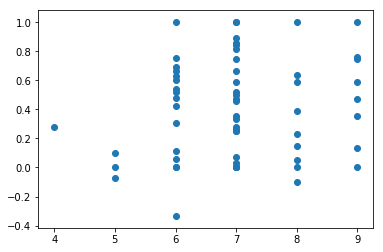

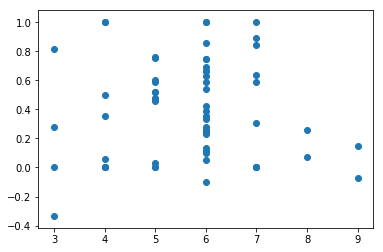

In [176]:
#How many hubs change for subject in connectome_full to only healthy?
overlap_connectomes_ta = []
overlap_connectomes_tc = []
overlap_connectomes_ta_d = []
overlap_connectomes_tc_d = []

for idx in range(len(subjects)-1):
    overlap_connectomes_ta.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_tc.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_ta_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))
    overlap_connectomes_tc_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))

print(np.mean(overlap_connectomes_ta), np.std(overlap_connectomes_ta))
print(np.mean(overlap_connectomes_tc), np.std(overlap_connectomes_tc))
print(np.mean(overlap_connectomes_ta_d), np.std(overlap_connectomes_ta_d))
print(np.mean(overlap_connectomes_tc_d), np.std(overlap_connectomes_tc_d))


plt.figure()
plt.scatter(np.asarray(overlap_connectomes_ta)[:], df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(np.asarray(overlap_connectomes_tc)[:], df_clinical.iloc[:]['improvement'])  

No relation between similarity and overlap of hubs of full and only healthy connectome and the clinical improvement. However, in time there is a decrease in overlap between the full and only healthy conn -> showing that the the healthy brain is re-organizing. From the above analyses, it seems that how the brain reorganize structurally is not the same across subjects. Some loss of overlap is indeed given by the fact that some edges are now belonging to the dysconnectome. In fact, most of the loss of overlap is in hubs that would normally be present in the affected hemisphere.

Text(0.5, 1.0, 'Ca full hubs')

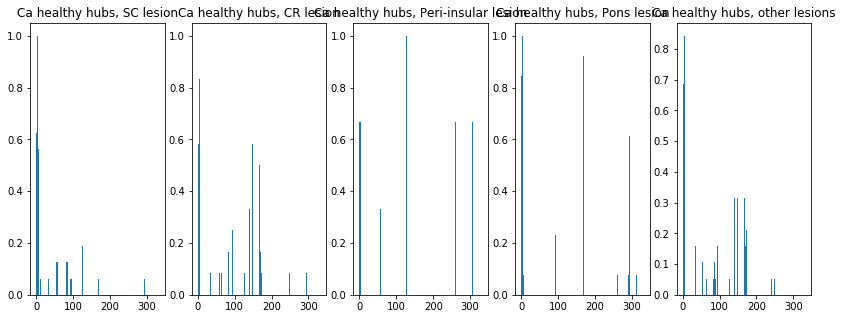

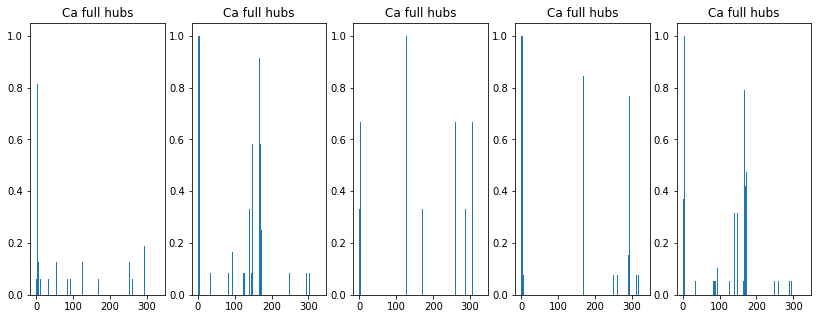

In [153]:
fig, axs = plt.subplots(1,5, figsize=(14,5))
Ca_SC_h, Ca_SC_bin, _ = axs[0].hist(np.asarray(hubs_Ca_h)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_h)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Ca healthy hubs, SC lesion')
Ca_CR_h, Ca_CR_bin, _ = axs[1].hist(np.asarray(hubs_Ca_h)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_h)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Ca healthy hubs, CR lesion')
Ca_peri_h, Ca_peri_bin, _ = axs[2].hist(np.asarray(hubs_Ca_h)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_h)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Ca healthy hubs, Peri-insular lesion')
Ca_pons_h, Ca_pons_bin, _ = axs[3].hist(np.asarray(hubs_Ca_h)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_h)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Ca healthy hubs, Pons lesion')
Ca_all_h, Ca_all_bin, _ = axs[4].hist(np.asarray(hubs_Ca_h)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_h)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Ca healthy hubs, other lesions')

fig, axs = plt.subplots(1,5, figsize=(14,5))
Ca_SC_f, Ca_SC_bin, _ = axs[0].hist(np.asarray(hubs_Ca_f)[SC_idx[0]].reshape(len(SC_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_f)[SC_idx[0]].reshape(len(SC_idx[0])*10))/len(SC_idx[0]));
axs[0].set_title('Ca full hubs')
Ca_CR_f, Ca_CR_bin, _ = axs[1].hist(np.asarray(hubs_Ca_f)[CR_idx[0]].reshape(len(CR_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_f)[CR_idx[0]].reshape(len(CR_idx[0])*10))/len(CR_idx[0]));
axs[1].set_title('Ca full hubs')
Ca_peri_f, Ca_peri_bin, _ = axs[2].hist(np.asarray(hubs_Ca_f)[peri_idx[0]].reshape(len(peri_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_f)[peri_idx[0]].reshape(len(peri_idx[0])*10))/len(peri_idx[0]));
axs[2].set_title('Ca full hubs')
Ca_pons_f, Ca_pons_bin, _ = axs[3].hist(np.asarray(hubs_Ca_f)[pons_idx[0]].reshape(len(pons_idx[0])*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_f)[pons_idx[0]].reshape(len(pons_idx[0])*10))/len(pons_idx[0]));
axs[3].set_title('Ca full hubs')
Ca_all_f, Ca_all_bin, _ = axs[4].hist(np.asarray(hubs_Ca_f)[others_idx].reshape(len(others_idx)*10), bins=np.linspace(0,332,333),weights=np.ones_like(np.asarray(hubs_Ca_f)[others_idx].reshape(len(others_idx)*10))/len(others_idx));
axs[4].set_title('Ca full hubs')




In [166]:
overlap_connectomes_SC = []
overlap_connectomes_CR = []
overlap_connectomes_peri = []
overlap_connectomes_pons = []
overlap_connectomes_others = []

overlap_connectomes_SC_d = []
overlap_connectomes_CR_d = []
overlap_connectomes_peri_d = []
overlap_connectomes_pons_d = []
overlap_connectomes_others_d = []

for idx in SC_idx[0]:
    overlap_connectomes_SC.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_SC_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))
    
for idx in CR_idx[0]: 
    overlap_connectomes_CR.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_CR_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))
    
for idx in pons_idx[0]: 
    overlap_connectomes_pons.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_pons_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))
    
for idx in peri_idx[0]: 
    overlap_connectomes_peri.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_peri_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))
for idx in others_idx: 
    overlap_connectomes_others.append(len(set(hubs_Ca_f[idx]) & set(hubs_Ca_h[idx])))
    overlap_connectomes_others_d.append(len(set(hubs_Ca_f[idx]) & set(hubs_Da[idx])))

As expected, the healthy connectome has many more hubs overlapping with the full connectome, compared to the respective dysconnectome. Also, we can see that dirctly from the acute phase, some hubs of the full connectome are lost and not beloning to either of the 2 subnetworks. This is probably a sign that edges belonging to the initial connectome hub are half lesioned, but in neither subgraphs the number of edges makes the node remain a hub.

In [167]:
overlap_c_h_ta = overlap_connectomes_CR + overlap_connectomes_SC + overlap_connectomes_peri + overlap_connectomes_pons + overlap_connectomes_others
overlap_c_d_ta = overlap_connectomes_CR_d + overlap_connectomes_SC_d + overlap_connectomes_peri_d + overlap_connectomes_pons_d + overlap_connectomes_others_d
print(np.mean(overlap_c_d_ta), np.std(overlap_c_d_ta))
print(np.mean(overlap_c_h_ta), np.std(overlap_c_h_ta))

1.9047619047619047 1.2936264483053452
7.0 1.1126972805283737


In [168]:
# in chronic phase:
overlap_connectomes_SC = []
overlap_connectomes_CR = []
overlap_connectomes_peri = []
overlap_connectomes_pons = []
overlap_connectomes_others = []

overlap_connectomes_SC_d = []
overlap_connectomes_CR_d = []
overlap_connectomes_peri_d = []
overlap_connectomes_pons_d = []
overlap_connectomes_others_d = []

for idx in SC_idx[0]:
    overlap_connectomes_SC.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_SC_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))
    
for idx in CR_idx[0]: 
    overlap_connectomes_CR.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_CR_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))
    
for idx in pons_idx[0]: 
    overlap_connectomes_pons.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_pons_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))
    
for idx in peri_idx[0]: 
    overlap_connectomes_peri.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_peri_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))
for idx in others_idx: 
    overlap_connectomes_others.append(len(set(hubs_Cc_f[idx]) & set(hubs_Cc_h[idx])))
    overlap_connectomes_others_d.append(len(set(hubs_Cc_f[idx]) & set(hubs_Dc[idx])))

In [169]:
overlap_c_h_tc = overlap_connectomes_CR + overlap_connectomes_SC + overlap_connectomes_peri + overlap_connectomes_pons + overlap_connectomes_others
overlap_c_d_tc = overlap_connectomes_CR_d + overlap_connectomes_SC_d + overlap_connectomes_peri_d + overlap_connectomes_pons_d + overlap_connectomes_others_d
print(np.mean(overlap_c_d_tc), np.std(overlap_c_d_tc))
print(np.mean(overlap_c_h_tc), np.std(overlap_c_h_tc))

2.5873015873015874 1.609839986477219
5.650793650793651 1.3112302494008496


In the chronic phase, we can see quite a big decrease in hubs overlap in the connectome, and a higher overlap in the dysconnectomes

In [172]:
# is there a signficant difference between the overlaps between acute and chronic?
print(scipy.stats.ttest_ind(overlap_c_h_ta, overlap_c_h_tc))
print(scipy.stats.ttest_ind(overlap_c_d_ta, overlap_c_d_tc))

Ttest_indResult(statistic=6.177570606591289, pvalue=8.573997282455253e-09)
Ttest_indResult(statistic=-2.6023246478444677, pvalue=0.010387395095905222)


The difference is significant between chronic and acute for both dysconnectomes

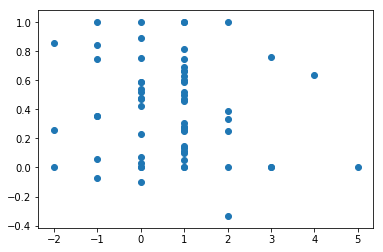

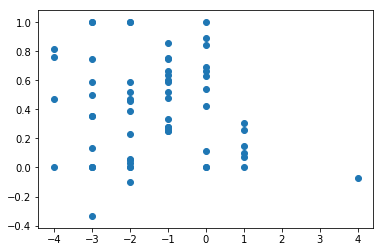

In [179]:
# Is the difference in overlap related to improvement in clinical score?
overlap_diff_c_h = np.asarray(overlap_connectomes_tc) - np.asarray(overlap_connectomes_ta)
overlap_diff_c_d = np.asarray(overlap_connectomes_tc_d) - np.asarray(overlap_connectomes_ta_d)
plt.figure()
plt.scatter(overlap_diff_c_d, df_clinical.iloc[:]['improvement'])
plt.figure()
plt.scatter(overlap_diff_c_h, df_clinical.iloc[:]['improvement'])

If in the unaffected connectome, the overlap of hubs with the full connectome decrease in time, it supports the fact that positive changes and new edges are forming in other nodes. However, this is not related with clinical improvement

In [193]:
# When looking at the different lesions, are the maximum of re-organization in same area?
# get the matrices of the degrees considering only these indices
most_5areas_SC_d = []
most_5areas_SC_h = []
most_5areas_CR_d = []
most_5areas_CR_h = []
most_5areas_pons_d = []
most_5areas_pons_h = []
most_5areas_peri_d = []
most_5areas_peri_h = []
most_5areas_others_d = []
most_5areas_others_h = []
# for each subject belonging to the same group, see if the 5 locations where biggest chang occurs are the same 
for idx in range(len(SC_idx[0])):
    most_5areas_SC_d.append(list(np.unravel_index(np.argsort(diff_aff_avg_deg_SC[:,idx], axis=None), diff_aff_avg_deg_SC[:,idx].shape)[0][-6:-1]))
    most_5areas_SC_h.append(list(np.unravel_index(np.argsort(diff_unaff_avg_deg_SC[:,idx], axis=None), diff_unaff_avg_deg_SC[:,idx].shape)[0][-6:-1]))
most_5areas_SC_d_flat = np.asarray(most_5areas_SC_d).reshape(5*len(SC_idx[0]))
most_5areas_SC_h_flat = np.asarray(most_5areas_SC_h).reshape(5*len(SC_idx[0]))

for idx in range(len(CR_idx[0])):
    most_5areas_CR_d.append(list(np.unravel_index(np.argsort(diff_aff_avg_deg_CR[:,idx], axis=None), diff_aff_avg_deg_CR[:,idx].shape)[0][-6:-1]))
    most_5areas_CR_h.append(list(np.unravel_index(np.argsort(diff_unaff_avg_deg_CR[:,idx], axis=None), diff_unaff_avg_deg_CR[:,idx].shape)[0][-6:-1]))
most_5areas_CR_d_flat = np.asarray(most_5areas_CR_d).reshape(5*len(CR_idx[0]))
most_5areas_CR_h_flat = np.asarray(most_5areas_CR_h).reshape(5*len(CR_idx[0]))

for idx in range(len(pons_idx[0])):
    most_5areas_pons_d.append(list(np.unravel_index(np.argsort(diff_aff_avg_deg_pons[:,idx], axis=None), diff_aff_avg_deg_pons[:,idx].shape)[0][-6:-1]))
    most_5areas_pons_h.append(list(np.unravel_index(np.argsort(diff_unaff_avg_deg_pons[:,idx], axis=None), diff_unaff_avg_deg_pons[:,idx].shape)[0][-6:-1]))
most_5areas_pons_d_flat = np.asarray(most_5areas_pons_d).reshape(5*len(pons_idx[0]))
most_5areas_pons_h_flat = np.asarray(most_5areas_pons_h).reshape(5*len(pons_idx[0]))

for idx in range(len(peri_idx[0])):
    most_5areas_peri_d.append(list(np.unravel_index(np.argsort(diff_aff_avg_deg_peri[:,idx], axis=None), diff_aff_avg_deg_peri[:,idx].shape)[0][-6:-1]))
    most_5areas_peri_h.append(list(np.unravel_index(np.argsort(diff_unaff_avg_deg_peri[:,idx], axis=None), diff_unaff_avg_deg_peri[:,idx].shape)[0][-6:-1]))
most_5areas_peri_d_flat = np.asarray(most_5areas_peri_d).reshape(5*len(peri_idx[0]))
most_5areas_peri_h_flat = np.asarray(most_5areas_peri_h).reshape(5*len(peri_idx[0]))

for idx in range(len(others_idx)):
    most_5areas_others_d.append(list(np.unravel_index(np.argsort(diff_aff_avg_deg_others[:,idx], axis=None), diff_aff_avg_deg_others[:,idx].shape)[0][-6:-1]))
    most_5areas_others_h.append(list(np.unravel_index(np.argsort(diff_unaff_avg_deg_others[:,idx], axis=None), diff_unaff_avg_deg_others[:,idx].shape)[0][-6:-1]))
most_5areas_others_d_flat = np.asarray(most_5areas_others_d).reshape(5*len(others_idx))
most_5areas_others_h_flat = np.asarray(most_5areas_others_h).reshape(5*len(others_idx))

Text(0.5, 1.0, 'Others healthy connectome changes')

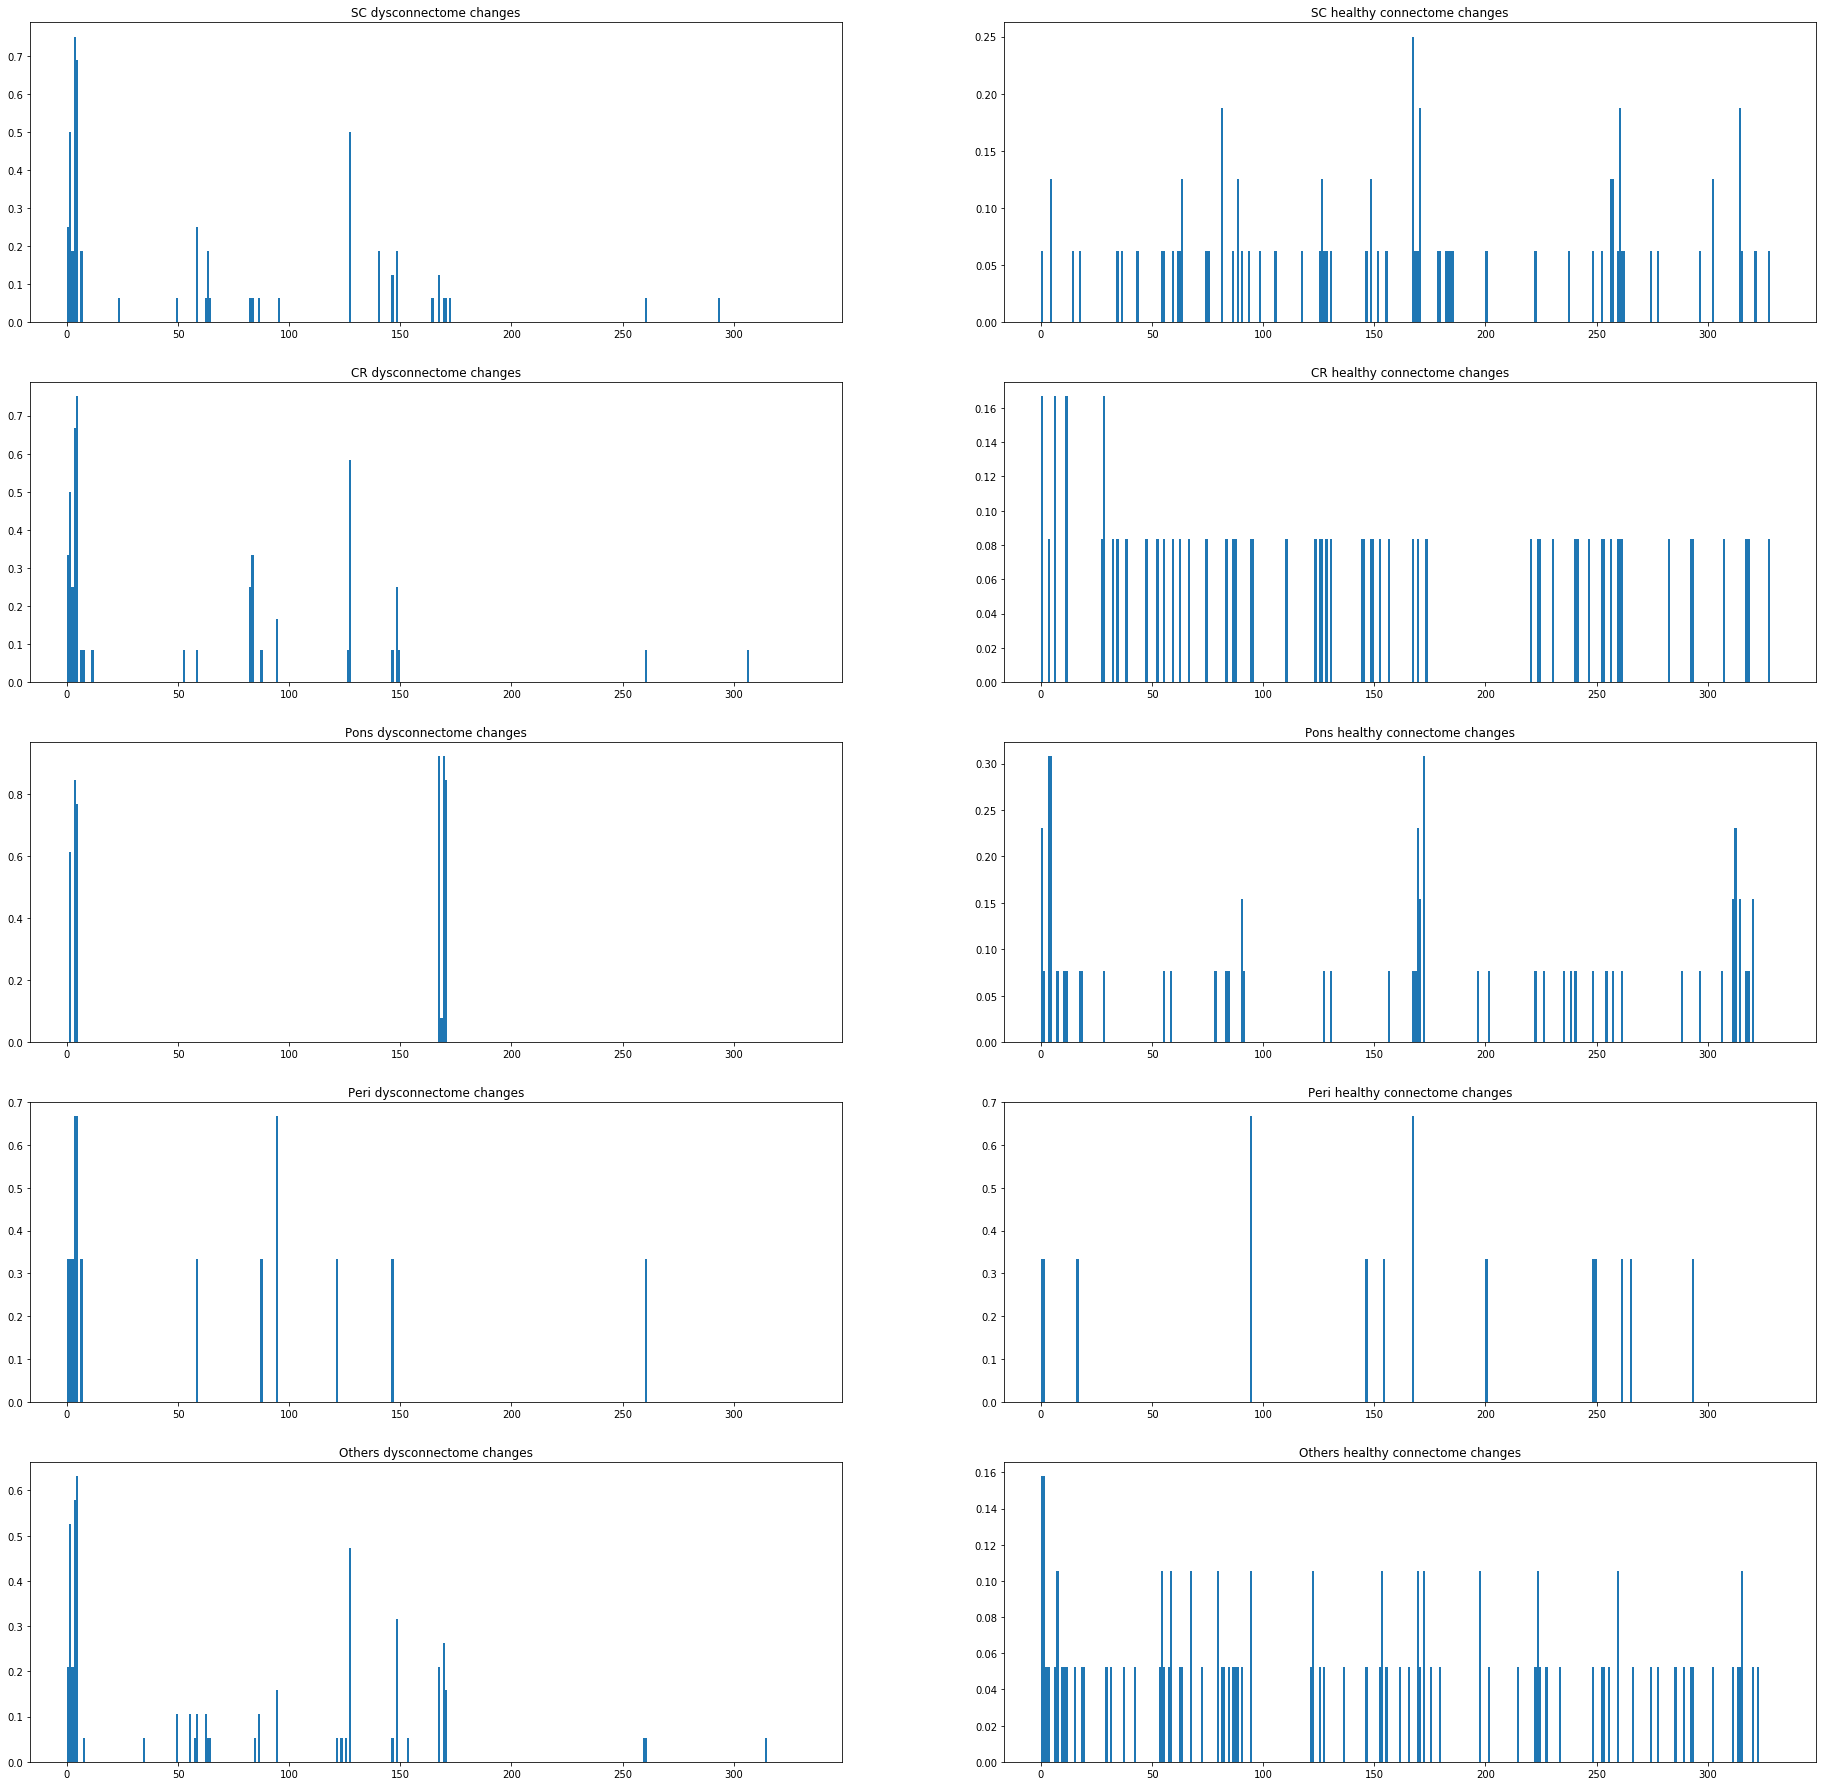

In [197]:
fig, axs = plt.subplots(5, 2, figsize=(32,32))
SC_d_heighs, _,_ =axs[0][0].hist(most_5areas_SC_d_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_SC_d_flat)/np.size(SC_idx))
axs[0][0].set_title('SC dysconnectome changes')
SC_d_heighs, _,_ =axs[0][1].hist(most_5areas_SC_h_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_SC_h_flat)/np.size(SC_idx))
axs[0][1].set_title('SC healthy connectome changes')
CR_d_heighs, _,_ =axs[1][0].hist(most_5areas_CR_d_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_CR_d_flat)/np.size(CR_idx))
axs[1][0].set_title('CR dysconnectome changes')
CR_h_heighs, _,_ =axs[1][1].hist(most_5areas_CR_h_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_CR_h_flat)/np.size(CR_idx))
axs[1][1].set_title('CR healthy connectome changes')
pons_d_heighs, _,_ =axs[2][0].hist(most_5areas_pons_d_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_pons_d_flat)/np.size(pons_idx))
axs[2][0].set_title('Pons dysconnectome changes')
pons_h_heighs, _,_ =axs[2][1].hist(most_5areas_pons_h_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_pons_h_flat)/np.size(pons_idx))
axs[2][1].set_title('Pons healthy connectome changes')
peri_d_heighs, _,_ =axs[3][0].hist(most_5areas_peri_d_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_peri_d_flat)/np.size(peri_idx))
axs[3][0].set_title('Peri dysconnectome changes')
peri_h_heighs, _,_ =axs[3][1].hist(most_5areas_peri_h_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_peri_h_flat)/np.size(peri_idx))
axs[3][1].set_title('Peri healthy connectome changes')
others_d_heighs, _,_ =axs[4][0].hist(most_5areas_others_d_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_others_d_flat)/np.size(others_idx))
axs[4][0].set_title('Others dysconnectome changes')
others_h_heighs, _,_ =axs[4][1].hist(most_5areas_others_h_flat, bins=np.linspace(0,332,333), weights=np.ones_like(most_5areas_others_h_flat)/np.size(others_idx))
axs[4][1].set_title('Others healthy connectome changes')

The healthy part of the brain does not re-organize in similar manner if the lesion is in the same location. More similar changes are actually seen in the dysconnectome. But there is no node undergoing big changes equal for all subjects in one group. However, along subjects (belonging also to different lesion groups), in the dysconnectome changes occur mostly in nodes belonging to the controlateral side and well connected areas (thalamus, putaments, etc). Only patients having a lesion in the Pons seem to be more consistent in re-organization, where many changes occur in the above-mentioned areas but on both hemispehres.It is also the group showing slightly more similarity within groups for connectome changes. 

In [219]:
# SWI and efficiency:
SWI_Ca_f = np.load('SWI_Ca_f.npy')
SWI_Cc_f = np.load('SWI_Cc_f.npy')
SWI_Ca_h = np.load('SWI_Ca.npy')
SWI_Cc_h = np.load('SWI_Cc.npy')
eff_Ca_f = np.load('eff_Ca_f.npy')
eff_Cc_f = np.load('eff_Cc_f.npy')
eff_Ca_h = np.load('eff_Ca.npy')
eff_Cc_h = np.load('eff_Cc.npy')
SWI_connectome_diff_ta = SWI_Ca_f - SWI_Ca_h
SWI_connectome_diff_tc = SWI_Cc_f - SWI_Cc_h
eff_connectome_diff_ta = eff_Ca_f - eff_Ca_h
eff_connectome_diff_tc = eff_Cc_f - eff_Cc_h

In [223]:
print('SWI acute')
print(np.mean(SWI_connectome_diff_ta), np.std(SWI_connectome_diff_ta))
print(scipy.stats.ttest_rel(SWI_Ca_f, SWI_Ca_h))
print('SWI chronic')
print(np.mean(SWI_connectome_diff_tc), np.std(SWI_connectome_diff_tc))
print(scipy.stats.ttest_rel(SWI_Cc_f, SWI_Cc_h))
print('eff acute')
print(np.mean(eff_connectome_diff_ta), np.std(eff_connectome_diff_ta))
print(scipy.stats.ttest_rel(eff_Ca_f, eff_Ca_h))
print('eff chronic')
print(np.mean(eff_connectome_diff_tc), np.std(eff_connectome_diff_tc))
print(scipy.stats.ttest_rel(eff_Cc_f, eff_Cc_h))

SWI acute
0.08891942022996727 0.07821973519151572
Ttest_relResult(statistic=8.951094162222004, pvalue=9.015198973408432e-13)
SWI chronic
0.0747785278112268 0.06555650005856449
Ttest_relResult(statistic=8.981667969867278, pvalue=7.989630979315066e-13)
eff acute
0.03147899812893996 0.030600817090520187
Ttest_relResult(statistic=8.099975840516446, pvalue=2.6546675889392635e-11)
eff chronic
0.026056674976218455 0.02543697543825741
Ttest_relResult(statistic=8.065835674186824, pvalue=3.042327128630132e-11)


In [259]:
# Plot average degree for 3 graphs in 2 time points 

acute_avg_deg_f = []
chronic_avg_deg_f = []

acute_avg_deg_h = []
chronic_avg_deg_h = []

acute_avg_deg_d = []
chronic_avg_deg_d = []

acute_deg_f = np.zeros((333, len(subjects)-1))
chronic_deg_f = np.zeros((333, len(subjects)-1))

acute_deg_h = np.zeros((333, len(subjects)-1))
chronic_deg_h = np.zeros((333, len(subjects)-1))

acute_deg_d = np.zeros((333, len(subjects)-1))
chronic_deg_d = np.zeros((333, len(subjects)-1))



for idx, subject in enumerate(subjects):
    if os.path.isdir('Data_Dysconnectome/'+subject):
        # load the orginial adj matrices
        Ca = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_ta.txt')
        Da = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_ta.txt')
        Cc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_connectome_HD_FA_tc.txt')
        Dc = np.loadtxt('Data_Dysconnectome/'+subject+'/analysis/VECTOR_dysconnectome_HD_tc.txt')
        # delete the medial walls:
        Ca = np.delete(Ca, (174), axis=0)#173
        Ca = np.delete(Ca, (174), axis=1)
        Ca = np.delete(Ca, (7), axis=0)
        Ca = np.delete(Ca, (7), axis=1)
        Da = np.delete(Da, (174), axis=0)
        Da = np.delete(Da, (174), axis=1)
        Da = np.delete(Da, (7), axis=0)
        Da = np.delete(Da, (7), axis=1)
        Cc = np.delete(Cc, (174), axis=0)
        Cc = np.delete(Cc, (174), axis=1)
        Cc = np.delete(Cc, (7), axis=0)
        Cc = np.delete(Cc, (7), axis=1)
        Dc = np.delete(Dc, (174), axis=0)
        Dc = np.delete(Dc, (174), axis=1)
        Dc = np.delete(Dc, (7), axis=0)
        Dc = np.delete(Dc, (7), axis=1)
        
        # Remove self-connections
        np.fill_diagonal(Ca, 0)
        np.fill_diagonal(Da, 0)
        np.fill_diagonal(Cc, 0)
        np.fill_diagonal(Dc, 0)
        
        # binarize (for dysconnectome, higher thrshold set as we want to avoid taking too many false-positive)
        Ca_bin = (Ca > 0)*1
        Da_bin = (Da > 0.1)*1
        Cc_bin = (Cc > 0)*1
        Dc_bin = (Dc > 0.1)*1

        
        # create healthy connectomes
        Ca_h_bin = Ca_bin - Da_bin
        Cc_h_bin = Cc_bin - Dc_bin
        
        # get the degree of the new connectomes
        Ca_healthy_t = np.transpose(Ca_h_bin)
        degree_Ca_h = np.sum(Ca_h_bin + Ca_healthy_t, axis=0) 
        Cc_healthy_t = np.transpose(Cc_h_bin)
        degree_Cc_h = np.sum(Cc_h_bin + Cc_healthy_t, axis=0) 
        
        Da_t = np.transpose(Da_bin)
        degree_Da = np.sum(Da_bin + Da_t, axis=0)
        Dc_t = np.transpose(Dc_bin)
        degree_Dc = np.sum(Dc_bin + Dc_t, axis=0)
        
        Ca_t = np.transpose(Ca_bin)
        degree_Ca_f = np.sum(Ca_bin + Ca_t, axis=0) 
        Cc_t = np.transpose(Cc_bin)
        degree_Cc_f = np.sum(Cc_bin + Cc, axis=0) 
        
        acute_deg_h[:,idx-1] = degree_Ca_h
        chronic_deg_h[:,idx-1] = degree_Cc_h
        
        acute_deg_f[:,idx-1] = degree_Ca_f
        chronic_deg_f[:,idx-1] = degree_Cc_f
        
        acute_deg_d[:,idx-1] = degree_Da
        chronic_deg_d[:,idx-1] = degree_Dc
        
        acute_avg_deg_h.append(np.mean(degree_Ca_h))
        chronic_avg_deg_h.append(np.mean(degree_Cc_h))
        
        acute_avg_deg_d.append(np.mean(degree_Da))
        chronic_avg_deg_d.append(np.mean(degree_Dc))

        acute_avg_deg_f.append(np.mean(degree_Ca_f))
        chronic_avg_deg_f.append(np.mean(degree_Cc_f))
         
       

Text(0.5, 0, 'Avg degree')

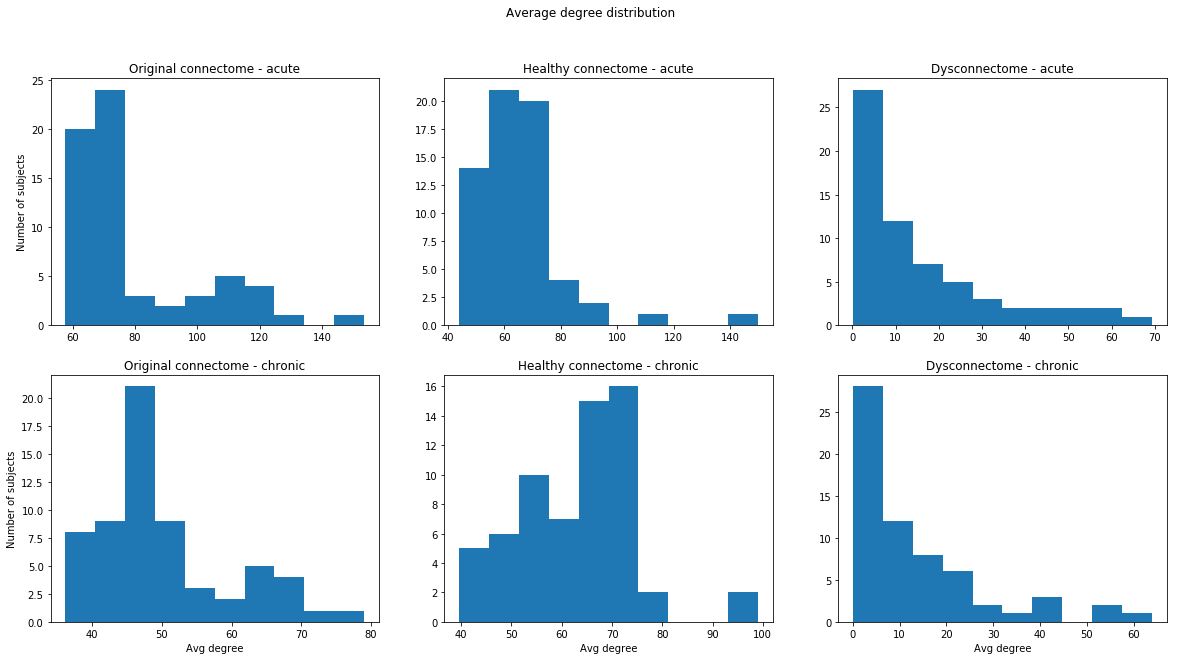

In [270]:
# Plot average degree for the 3 graphs (ta and tc)
fig, axs = plt.subplots(2,3, figsize=(20,10))
fig.suptitle('Average degree distribution')
axs[0][0].hist(acute_avg_deg_f)
axs[0][0].set_title('Original connectome - acute')
axs[0][0].set_ylabel('Number of subjects')
axs[0][1].hist(acute_avg_deg_h)
axs[0][1].set_title('Healthy connectome - acute')
axs[0][2].hist(acute_avg_deg_d)
axs[0][2].set_title('Dysconnectome - acute')
axs[1][0].hist(chronic_avg_deg_f)
axs[1][0].set_title('Original connectome - chronic')
axs[1][0].set_ylabel('Number of subjects')
axs[1][0].set_xlabel('Avg degree')
axs[1][1].hist(chronic_avg_deg_h)
axs[1][1].set_title('Healthy connectome - chronic')
axs[1][1].set_xlabel('Avg degree')
axs[1][2].hist(chronic_avg_deg_d)
axs[1][2].set_title('Dysconnectome - chronic')
axs[1][2].set_xlabel('Avg degree')

20979


Text(0.5, 0, 'Degree')

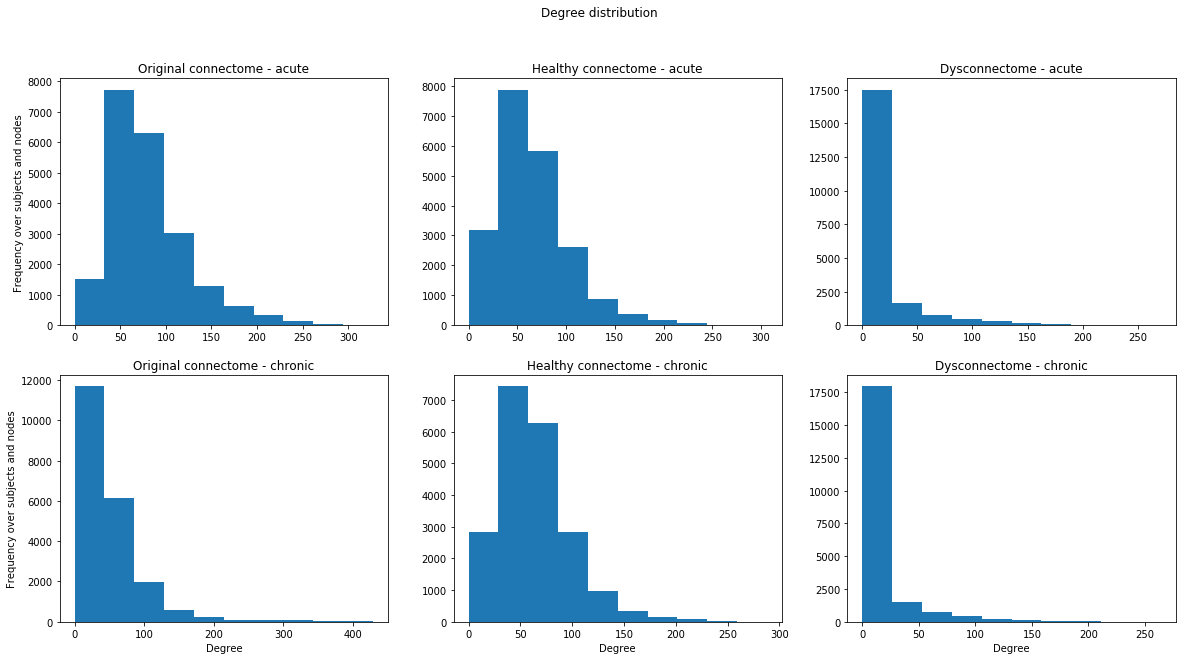

In [269]:
# Plot average degree for the 3 graphs (ta and tc)
print(333*63)
fig, axs = plt.subplots(2,3, figsize=(20,10))
fig.suptitle('Degree distribution')
axs[0][0].hist(acute_deg_f.reshape(333*63))#, weights=np.ones_like(acute_deg_f.reshape(333*63))/333)
axs[0][0].set_title('Original connectome - acute')
axs[0][0].set_ylabel('Frequency over subjects and nodes')
axs[0][1].hist(acute_deg_h.reshape(333*63))#, weights=np.ones_like(acute_deg_h.reshape(333*63))/333)
axs[0][1].set_title('Healthy connectome - acute')
axs[0][2].hist(acute_deg_d.reshape(333*63))#, weights=np.ones_like(acute_deg_d.reshape(333*63))/333)
axs[0][2].set_title('Dysconnectome - acute')
axs[1][0].hist(chronic_deg_f.reshape(333*63))#, weights=np.ones_like(chronic_deg_f.reshape(333*63))/333)
axs[1][0].set_title('Original connectome - chronic')
axs[1][0].set_ylabel('Frequency over subjects and nodes')
axs[1][0].set_xlabel('Degree')
axs[1][1].hist(chronic_deg_h.reshape(333*63))#, weights=np.ones_like(chronic_deg_h.reshape(333*63))/333)
axs[1][1].set_title('Healthy connectome - chronic')
axs[1][1].set_xlabel('Degree')
axs[1][2].hist(chronic_deg_d.reshape(333*63))#, weights=np.ones_like(chronic_deg_d.reshape(333*63))/333)
axs[1][2].set_title('Dysconnectome - chronic')
axs[1][2].set_xlabel('Degree')